In [138]:
import os
import requests 
import time
import string
import networkx as nx
import itertools
import networkx as nx
import pandas as pd
import json
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

from nltk.corpus import wordnet as wn #importing it
from nltk.stem.wordnet import WordNetLemmatizer #importing wordnet lemmatizer
from nltk import pos_tag #part-of-speech-tagger
from collections import defaultdict #defaultdict returns default value for non-existant keys you try to  access based on the function you passed in the constructor
#from google.colab import files

import heapq
import json
import re
import csv
from wordcloud import WordCloud
nltk.download('stopwords')

from operator import itemgetter
import  collections
from operator import itemgetter

import random

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/daniele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
path="../LIWK_files/"

america1L= pd.read_csv(path+'USA_JanFeb2020L.csv',dtype ={"Source (A)": str})
america2L= pd.read_csv(path+'USA_SeptOct2020L.csv',dtype ={"Source (A)": str})
america3L= pd.read_csv(path+'USA_MarchApril2021L.csv',dtype ={"Source (A)": str})

americaTL= pd.read_csv(path+'USAL.csv',dtype ={"Source (A)": str})


china1L= pd.read_csv(path+'China_JanFeb2020L.csv',dtype ={"Source (A)": str})
china2L= pd.read_csv(path+'China_SeptOct2020L.csv',dtype ={"Source (A)": str})
china3L= pd.read_csv(path+'China_MarchApril2021L.csv',dtype ={"Source (A)": str})

chinaTL= pd.read_csv(path+'ChinaL.csv',dtype ={"Source (A)": str})

In [12]:
def plot_wordcloud(dictionary):
    wordcloud = WordCloud(background_color='white',
                          width=1500,
                          height=1000
                          ).generate_from_frequencies(dictionary)
    # use .generate(space_separated_string) - to generate cloud from text

    plt.figure(figsize=(9,6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# functions from NS_word_meas
def cleaner(tweet,word_list = stopwords.words('english')):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    tweet = tweet.translate(table)# remove punctuation

    special_characters = ['rt','dr','“','rt','the','to','of','a','an','on','has','have','had','is','was','did','n','et','ha','lt','1','2','5']

    tweet = tweet.split()      
    tweet = ' '.join([ word for word in tweet if word not in word_list and word not in special_characters  ])   #remove useless words
    return tweet



#initialize an empty dict

def frequency_dictionary(df):
    unique_words = {}

    for row in df:
        for word in row.split():
            #if the word is encountered for the first time add to dict as key and set its value to 0
            unique_words.setdefault(word,0)
            #increase the value (i.e the count) of the word by 1 every time it is encountered
            unique_words[word] += 1

    return unique_words

def frequency_marker_dictionary(df,df2,markstring):   ##dummy marker assignment
    mark_words = {}
    count_words = {}
    i=0
    for row in df:
        for word in row.split():
            #if the word is encountered for the first time add to dict as key and set its value to 0
            mark_words.setdefault(word, 0)
            count_words.setdefault(word, 0)
            #increase the value of a word by the average of the previous values and the new one tweet value
            mark_words[word] = mark_words[word] + df2.iloc[i][markstring]  
            count_words[word] += 1
        i+=1
    return mark_words, count_words

# this is the code provided by Lejla for cleaning, lemmatising and pos tagging tweets

nltk.download('words')
words = set(nltk.corpus.words.words()) #the last two lines serve to download the corpus of standard English language words
nltk.download('stopwords') #downloading stopwords
stop_words = set(nltk.corpus.stopwords.words("english")) #taking the stop words from English language
nltk.download('wordnet') #downloading wordnet
from nltk.corpus import wordnet as wn #importing it
from nltk.stem.wordnet import WordNetLemmatizer #importing wordnet lemmatizer
from nltk import pos_tag #part-of-speech-tagger
nltk.download('averaged_perceptron_tagger') #downloading tagger
from collections import defaultdict #defaultdict returns default value for non-existant keys you try to  access based on the function you passed in the constructor
tag_map = defaultdict(lambda : wn.NOUN) #here we define that wn.NOUN is the default value for the dict
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemma_pos_cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase
    tweet = re.sub("'", " ", tweet)  # remove aphostrophe

    #basically we use pos_tag function on tokens that we get by applying wordpunct tokenization
    #to tweet (it separates all the words and symbols)
    #then we pass the token along with it's wordnet pos value that we get from the tag_map dictionary (noun, adjective, verb or adverb) to the lemma function (the WordNetLemmatizer())
    lemma_function = WordNetLemmatizer()
    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize

    # francesco: I removed also all 2 letters words and added specific words, words that appears frequently but are discarded because they are not in the english language and len(w)>2
    specific_words=['virus', 'coronavirus', 'covid19', 'covid', 'trump', 'hubei', 'beijing', 'xinjiang', 'jinping', 'korea', 'xinhua', 'india', 'taiwan','johnson','singapore', 'africa', 'japanese', 'france', 'asian', 'australia', 'french', 'asia', 'leishenshan', 'british', 'qingdao', 'fauci', 'america',  'california', 'sichuan', 'malaysia', 'huawei','thailand', 'shandong', 'italy', 'philippines', 'germany', 'facebook', 'african', 'shenzhen', 'tokyo', 'russian','uygur', '5g', 'pompeo', 'vietnam', 'australian', 'cambodia', 'zhejiang', 'yunnan', 'guangdong', 'korean', 'iran', 'washington']
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if (w in words or w in specific_words) and w not in stop_words ) #remove stop words
   
    return tweet

## Adjacency matrix building
def adj_matrix(freq_dict,cleaned_df_text):   

    words = sorted(list(freq_dict.keys()))

    A = pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words )

    for phrase in cleaned_df_text:

        words_list = phrase.split()

        couples = [(words_list[i],words_list[j]) for i in range(len(words_list)) for j in range(i+1,len(words_list))]

        for w1,w2 in couples:

              A.loc[w1,w2] += 1

    return np.maximum( A, A.transpose() )

def threshold(vector,threshold):

    l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

    print(pd.DataFrame(l))

    return 

[nltk_data] Downloading package words to /home/daniele/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/daniele/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/daniele/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/daniele/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
china1L["Source (B)"]

0        'CGTN talked to W. Ian Lipkin of Columbia Uni...
1        'Spring always brings along a lively vibe sat...
2        'February means carnival in Brazil. This year...
3        'China and the world has made great strides i...
4        'A fake news story about cases of COVID-19 in...
                              ...                        
3193     'Patients with no history of Wuhan travel con...
3194    Two cities to the east of Wuhan suspend railwa...
3195    Wuhan patient expected to recover from new pne...
3196     'Chinese Vice Premier Sun Chunlan orders all-...
3197    WHO experts visit Wuhan for pneumonia epidemic...
Name: Source (B), Length: 3198, dtype: object

In [30]:
def get_adj_matrix(df):
    text = [lemma_pos_cleaner(txt) for txt in df["Source (B)"]]
    freq_dict = frequency_dictionary(text)
    freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

    A = adj_matrix(freq_dict, text)
    return freq_dict, A

# create the unnormalized adjency matrix B of the bipartite graph!!!

def unm_adj_matrix(freq_dict,cleaned_df_text,id_tweet):   

    words = sorted(list(freq_dict.keys()))

    B = pd.DataFrame(np.zeros((len(cleaned_df_text),len(words))), columns = words, index = id_tweet )
    
    for i , phrase in enumerate(cleaned_df_text) :
        words_list = phrase.split()
        for w in words_list :
            
            B.loc[id_tweet.loc[i],w] = 1
    
    #B_tw_tw = pd.DataFrame(np.zeros((len(cleaned_df_text),len(cleaned_df_text))), columns = id_tweet, index = id_tweet )
    #B_w_w  =  pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words )    
    return B

def power_iteration(A, m_t0 ,num_simulations: int,alpha=0.85):
    '''
    A   : is the matrix of which you want the eigenvalue
    m_t0: is the starter value
    
    '''
    m_t=m_t0
    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        m_t1 = alpha * np.dot(A, m_t) + (1.-alpha)*m_t0
        
        # calculate the norm   (here I sum the whole vector and then I divide it)
        m_t1_norm = np.linalg.norm(m_t1,ord=1) 

        # re normalize the vector
        m_t = m_t1 / m_t1_norm #m_t1.sum()
        #print(m_t)

    return m_t



def pgrank_projection(df, emo = "negemo", n_iteration = 10, plotWC= True ):
    
    #check that the dataframe have no 0-words tweet
    check_df = len(df[df["WC"] == 0])
    if check_df != 0:
        print("dumping",check_df , "rows")
        df.drop(df[df["WC"] == 0].index, inplace=True, axis=0)  #notice it should affect the original df
        
    df_text = df["Source (B)"]
    id_tweet = df["Source (A)"].reset_index(drop=True)
    
    
    
    cleaned_df_text = [lemma_pos_cleaner(el) for el in df_text]
    marker_dict, freq_dict = frequency_marker_dictionary(cleaned_df_text, df, emo )

    B=unm_adj_matrix(freq_dict,cleaned_df_text,id_tweet )
    
    #spot difficulties in the dataframe : 
    #assert len(B.loc[B.sum(axis=1) == 0])== 0 , "Check the data !! Possible 0-word tweet!"
    check = B.loc[B.sum(axis=1) == 0]
    if len(check)!= 0  :  
        print(check.index)
        assert True, "Check the data !! Possible 0-word tweet!"
    
    
    B1 = B / np.linalg.norm(B,ord=1,axis=1, keepdims=True)
    
    B2_tmp = B / np.linalg.norm(B,ord=1,axis=0, keepdims=True)
    B2=B2_tmp.transpose()
    
    Mt = B1.dot(B2) #I started with the transposed B!!! 
    m_i = df[emo].reset_index(drop=True)
    
    m_t=power_iteration(Mt,m_i, n_iteration)
    m_w =B2.dot(np.array(m_t))
    if plotWC == True : plot_wordcloud(m_w.to_dict())
    
    return B, m_t , m_w 

In [18]:
#get adj matrixs
#take ages
fc1,Ac1 = get_adj_matrix(china1L)
fc2,Ac2 = get_adj_matrix(china2L)
fc3,Ac3 = get_adj_matrix(china3L)
fa1,Aa1 = get_adj_matrix(america1L)
fa2,Aa2 = get_adj_matrix(america2L)
fa3,Aa3 = get_adj_matrix(america3L)

C1 = nx.from_pandas_adjacency(Ac1)
C2 = nx.from_pandas_adjacency(Ac2)
C3 = nx.from_pandas_adjacency(Ac3)
A1 = nx.from_pandas_adjacency(Aa1)
A2 = nx.from_pandas_adjacency(Aa2)
A3 = nx.from_pandas_adjacency(Aa3)


In [66]:
america2L[america2L['Source (A)']== '1312041956084678656']["Source (B)"]
america2L.drop(america2L[america2L['Source (A)']== '1312041956084678656'].index, inplace=True, axis=0)

In [65]:
china2L[china2L['Source (A)']== '1316614782095482880']["Source (B)"]
china2L.drop(china2L[china2L['Source (A)']== '1316614782095482880'].index, inplace=True, axis=0)

In [73]:
china3L[china3L['Source (A)']== '1372064322671669248']["Source (B)"]
china3L.drop(china3L[china3L['Source (A)']== '1372064322671669248'].index, inplace=True, axis=0)
china3L.drop(china3L[china3L['Source (A)']== '1378361852212641793'].index, inplace=True, axis=0)

In [62]:
china1L[china1L['Source (A)']== '1222512218052235264']["Source (B)"]
china1L.drop(china1L[china1L['Source (A)']== '1222512218052235264'].index, inplace=True, axis=0)

In [183]:
def get_B_mw(df,emo_str):
    B,m_t_,m_w_ = pgrank_projection(df, emo = emo_str, n_iteration = 20, plotWC= False )
    m_w_ord =dict(sorted(m_w_.to_dict().items(), key=lambda item: item[1],reverse  = True))
    return m_w_ord
#take edges
emo="drives"
mw_c1 = get_B_mw(china1L,emo)
mw_c2 = get_B_mw(china2L,emo)
mw_c3 = get_B_mw(china3L,emo)
mw_a1 = get_B_mw(america1L,emo)
mw_a2 = get_B_mw(america2L,emo)
mw_a3 = get_B_mw(america3L,emo)

nx.set_node_attributes(C1, mw_c1,name = emo)
nx.set_node_attributes(C2, mw_c2,name = emo)
nx.set_node_attributes(C3, mw_c3,name = emo)
nx.set_node_attributes(A1, mw_a1,name = emo)
nx.set_node_attributes(A2, mw_a2,name = emo)
nx.set_node_attributes(A3, mw_a3,name = emo)

In [78]:
#density = nx.density(C1)
#print("Network density:", density)
#C1.nodes()

In [85]:
len(sorted(nx.connected_components(A3), key=len, reverse=True))

1

In [103]:

def node_removal_(selected_nodes_n, G,d=False):# to finish --------------------------------------------
    nodes_removed_n  = []
    if d==False :
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i])
    else:
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i][0])

    #Node Removal, for robustness, removing 1 by 1 starting by nodes with highest emo_projected_index
    G1_n = G.copy()
    list_density_n = [nx.density(G1_n)]
    nodes_rem_n = []
    for i, node in enumerate(nodes_removed_n):
        if (i % 1000 == 0):
            print("Removing ", i ,"/", len(nodes_removed_n))
        G1_n.remove_node(node)
        list_density_n.append(nx.density(G1_n))
        nodes_rem_n.append(i+1)  
        
    return list_density_n , nodes_rem_n

('unfriendly', 0.002865767179189025)

In [203]:

def node_removal_density(selected_nodes_n, G,d=False):
    nodes_removed_n  = []
    if d==False :
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i])
    else:
        for i,v in enumerate(selected_nodes_n):
            nodes_removed_n.append(selected_nodes_n[i][0])

    #Node Removal, for robustness, removing 1 by 1 starting by nodes with highest emo_projected_index
    G1_n = G.copy()
    list_density_n = [nx.density(G1_n)]
    nodes_rem_n = []
    for i, node in enumerate(nodes_removed_n):
        if (i % 1000 == 0):
            print("Removing ", i ,"/", len(nodes_removed_n))
        G1_n.remove_node(node)
        list_density_n.append(nx.density(G1_n))
        nodes_rem_n.append(i+1)  
        
    return list_density_n , nodes_rem_n

In [204]:
def node_removal_tot(G, emo,degree_order=True):
    
    degree_dict_d = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict_d, 'degree')
    sorted_degree_d = sorted(degree_dict_d.items(), key=itemgetter(1), reverse=True)
    number_removed_degree=len(sorted_degree_d)

    ### NODE REMOVE BY EMOTION
    Emo_index_dict_n   = nx.get_node_attributes(G,emo)
    sorted_Emo_index_n = sorted(Emo_index_dict_n.items(), key=itemgetter(1), reverse=True)
    selected_Emo_n     = [x[0] for x in sorted_Emo_index_n if x[1] < 120.0]
    ##
    if (degree_order) == True:   
        survivors_degree_d = {x:degree_dict_d[x] for x in degree_dict_d if x in selected_Emo_n}
        sorted_degree_d= sorted(survivors_degree_d.items(), key=itemgetter(1), reverse=True)
        selected_Emo_n      = [x[0] for x in sorted_Emo_index_n if x[1] < 120.0]

    selected_random_n  = random.sample(selected_Emo_n, len(selected_Emo_n))
    list_density_r ,nodes_rem_r = node_removal_density(selected_nodes_n =selected_random_n , G=G,d=False)
    
    
    selected_nodes_e = selected_Emo_n.copy()
    list_density_e ,nodes_rem_e = node_removal_density(selected_nodes_n =selected_nodes_e , G=G,d=False)
    
    #Here we select the nodes and sort them by degree
    selected_nodes_d = list(sorted_degree_d)[:number_removed_degree]
    list_density_d ,nodes_rem_d = node_removal_density(selected_nodes_n =selected_nodes_d , G=G,d=True)

        
    return list_density_e ,nodes_rem_e, list_density_d ,nodes_rem_d,list_density_r ,nodes_rem_r
    

In [205]:
y_e,x_e,y_d,x_d,y_r,x_r = node_removal_tot(A1, emo,True)

Removing  0 / 3418
Removing  1000 / 3418
Removing  2000 / 3418
Removing  3000 / 3418
Removing  0 / 3418
Removing  1000 / 3418
Removing  2000 / 3418
Removing  3000 / 3418
Removing  0 / 3418
Removing  1000 / 3418
Removing  2000 / 3418
Removing  3000 / 3418


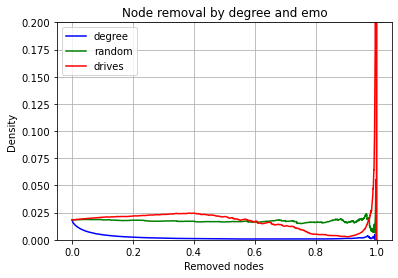

In [199]:
max_numb_iter = min([len(x_e), len(x_d),len(x_r)])
    

density_d_arr = np.array(y_d)[:max_numb_iter]
density_e_arr = np.array(y_e)[:max_numb_iter]
density_r_arr = np.array(y_r)[:max_numb_iter]

x= np.array(x_d)/max_numb_iter
    
plt.plot(x[:max_numb_iter], density_d_arr, 'b-', label = 'degree')
plt.plot(x[:max_numb_iter], density_r_arr, 'g-', label = 'random')
plt.plot(x[:max_numb_iter], density_e_arr, 'r-', label = emo)
    
plt.title("Node removal by "+'degree and emo')
plt.ylabel("Density")
plt.xlabel("Removed nodes")
plt.ylim(0,0.2)
plt.legend()
plt.grid 

In [215]:
#file= "../prova_robustness/china1"

In [276]:
def compute_centrality(g,mode='degree'):
    if mode == 'degree' :
        nodes_degrees = nx.degree_centrality(g)
    elif mode == 'closeness':   
        nodes_degrees = nx.closeness_centrality(g)
    elif mode == 'betweenness' :
        nodes_degrees = nx.betweenness_centrality(g)
    else : 
        print("aborted, error in compute_centrality")
        return
        

    max_centrality = max(nodes_degrees, key=nodes_degrees.get)
    #print('\n\tNode with Max number of Edges: ', max_centrality,
    #      ' ||' + str(mode), nodes_degrees[max_centrality])#, file=file)

    return max_centrality, nodes_degrees


In [ ]:
def graph_robustness(g,plotOn = True,diametersOn = False, plotDiametersOn = False):   #diameter take a lot of time
    length= len(g.nodes())
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_removed2 = [n+100 for n in range(0,len(g_remove_most_important.nodes() )-200,200 )   ]
    list_diameters = []
    list_diameters_number = []
    list_diameters_max = []
    list_diameters_min = []
    list_giantcomponentnodes = []
    
    
    print("::: Computing Degree :::")
    for x in range(length):
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            if diametersOn:
                diameters = [nx.diameter(comp) for comp in comps]
                list_diameters_max.append(max(diameters))
                list_diameters_min.append(min(diameters))
                list_diameters.append(sum(diameters) / len(diameters))
                list_diameters_number.append(x)

                if plotDiametersOn and x == 1000:
                    degree = dict(giant_comp.degree())
                    plot_distribution(degree.values(), 'degree')

            list_giantcomponentnodes.append(comp_nodes_number)
        
        list_components.append(comp_len)
        list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])


    g_remove_most_important = g.copy()
    list_components2 = []
    list_giantcomponentnodes2 = []
    list_diameters2 = []
    list_diameters_number2 = []
    list_diameters_max2 = []
    list_diameters_min2 = []

    print("::: Computing Closeness :::")
    lent=len(list_removed2)
    for x in range(lent):
        print('----- Nodes removed: ', x, ' -----')
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'closeness')
        first_nodes = heapq.nlargest(200, nodes, key=nodes.get)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )

        comp_len = len(comps)
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()

        if diametersOn:
            diameters = [nx.diameter(comp) for comp in comps]
            list_diameters_max2.append(max(diameters))
            list_diameters_min2.append(min(diameters))
            list_diameters2.append(sum(diameters) / len(diameters))
            list_diameters_number2.append(x)

            
        list_giantcomponentnodes2.append(comp_nodes_number)
        list_components2.append(comp_len)

        g_remove_most_important.remove_nodes_from(first_nodes)

    
    g_remove_most_important = g.copy()
    list_components3 = []
    list_giantcomponentnodes3 = []
    list_diameters3 = []
    list_diameters_number3 = []
    list_diameters_max3 = []
    list_diameters_min3 = []

    print("::: Computing Betweenness :::")
    for x in range(lent):
        print('----- Nodes removed: ', x, ' -----')
        best_node, nodes = compute_centrality(g_remove_most_important,mode = 'betweenness')
        first_nodes = heapq.nlargest(200, nodes, key=nodes.get)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        comp_len = len(comps)
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()

        if diametersOn:
            diameters = [nx.diameter(comp) for comp in comps]
            list_diameters_max3.append(max(diameters))
            list_diameters_min3.append(min(diameters))
            list_diameters3.append(sum(diameters) / len(diameters))
            list_diameters_number3.append(x)

            if plotDiametersOn and x == 10:
                degree = dict(giant_comp.degree())
                plot_distribution(degree.values(), 'degree')

        list_giantcomponentnodes3.append(comp_nodes_number)
        list_components3.append(comp_len)

        g_remove_most_important.remove_nodes_from(first_nodes)


    if plotOn:
        print("::: Plotting :::")
        # Plot of different centrality algo
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed2, list_components2, 'b-')
        plt.plot(list_removed2, list_components3, 'g-')
        plt.ylabel("Components number")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness'], loc='lower right')
        #plt.savefig('data/' + 'centralitiescomponents' + '.png', dpi=500)
        plt.show()

        # Plot of Giant Component nodes number
        plt.plot(list_diameters_number, list_giantcomponentnodes, 'r-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'b-')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'g-')
        plt.ylabel("Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness'], loc='upper right')
        #plt.savefig('data/' + 'giantcomponents' + '.png', dpi=500)
        plt.show()
        if diametersOn:
            # Plot of degree diameters
            plt.plot(list_removed2, list_diameters_max, 'r-')
            plt.plot(list_removed2, list_diameters_min, 'b-')
            plt.plot(list_removed2, list_diameters, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_degree' + '.png', dpi=500)
            plt.show()

            # Plot of closeness diameters
            plt.plot(list_removed2, list_diameters_max2, 'r-')
            plt.plot(list_removed2, list_diameters_min2, 'b-')
            plt.plot(list_removed2, list_diameters2, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_closeness' + '.png', dpi=500)
            plt.show()

            # Plot of betweenness diameters
            plt.plot(list_removed2, list_diameters_max3, 'r-')
            plt.plot(list_removed2, list_diameters_min3, 'b-')
            plt.plot(list_removed2, list_diameters3, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_betweenness' + '.png', dpi=500)
            plt.show()

        # Plot of giant + components
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed2, list_components2, 'b-')
        plt.plot(list_removed2, list_components3, 'g-')

        plt.plot(list_removed2, list_giantcomponentnodes, 'c-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'm-')
        plt.plot(list_removed2, list_giantcomponentnodes3, 'y-')

        plt.ylabel("Components number and Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'Closeness', 'Betweenness', 'Degree_Giant', 'Closeness_Giant', 'Betweenness_Giant'],
                   loc='upper right')
        #plt.savefig('data/' + 'centralities_and_giant' + '.png', dpi=500)
        plt.show()

::: Computing Degree :::

	Node with Max number of Edges:  china  ||degree 0.7727272727272728

	Node with Max number of Edges:  n  ||degree 0.5518649605227335

	Node with Max number of Edges:  novel  ||degree 0.4844771241830066

	Node with Max number of Edges:  outbreak  ||degree 0.4017978752383547

	Node with Max number of Edges:  coronavirus  ||degree 0.3904632152588556

	Node with Max number of Edges:  say  ||degree 0.3875715453802126

	Node with Max number of Edges:  people  ||degree 0.31652126499454747

	Node with Max number of Edges:  fight  ||degree 0.31224434142350693

	Node with Max number of Edges:  new  ||degree 0.27932351336606653

	Node with Max number of Edges:  epidemic  ||degree 0.2761255115961801

	Node with Max number of Edges:  hospital  ||degree 0.25736899563318777

	Node with Max number of Edges:  patient  ||degree 0.2541632541632542

	Node with Max number of Edges:  u  ||degree 0.2539595849262698

	Node with Max number of Edges:  virus  ||degree 0.2518437585359191


	Node with Max number of Edges:  quarantine  ||degree 0.07084621872364352

	Node with Max number of Edges:  close  ||degree 0.0703037120359955

	Node with Max number of Edges:  line  ||degree 0.07004219409282701

	Node with Max number of Edges:  makeshift  ||degree 0.07006190208216095

	Node with Max number of Edges:  back  ||degree 0.06923726428370391

	Node with Max number of Edges:  general  ||degree 0.06925675675675676

	Node with Max number of Edges:  wang  ||degree 0.069276260208392

	Node with Max number of Edges:  cause  ||degree 0.06873239436619719

	Node with Max number of Edges:  authority  ||degree 0.06818822203437587

	Node with Max number of Edges:  build  ||degree 0.06792559188275084

	Node with Max number of Edges:  confirmed  ||degree 0.06766281364533408

	Node with Max number of Edges:  combat  ||degree 0.06739988719684152

	Node with Max number of Edges:  director  ||degree 0.06713681241184767

	Node with Max number of Edges:  family  ||degree 0.06687358916478554

	


	Node with Max number of Edges:  post  ||degree 0.035547785547785545

	Node with Max number of Edges:  create  ||degree 0.03526668609734771

	Node with Max number of Edges:  join  ||degree 0.03527696793002916

	Node with Max number of Edges:  phone  ||degree 0.035287255759696705

	Node with Max number of Edges:  university  ||degree 0.035297549591598594

	Node with Max number of Edges:  well  ||degree 0.03501604902246863

	Node with Max number of Edges:  aid  ||degree 0.034734384121424405

	Node with Max number of Edges:  food  ||degree 0.03474452554744526

	Node with Max number of Edges:  concern  ||degree 0.03417056074766355

	Node with Max number of Edges:  deal  ||degree 0.03418054338299737

	Node with Max number of Edges:  near  ||degree 0.034190531852717705

	Node with Max number of Edges:  vaccine  ||degree 0.03420052616194095

	Node with Max number of Edges:  economic  ||degree 0.033625730994152045

	Node with Max number of Edges:  plan  ||degree 0.03363556595495759

	Node wit


	Node with Max number of Edges:  end  ||degree 0.021765417170495766

	Node with Max number of Edges:  hard  ||degree 0.021771998790444513

	Node with Max number of Edges:  infected  ||degree 0.02177858439201452

	Node with Max number of Edges:  capital  ||degree 0.021482602118003024

	Node with Max number of Edges:  former  ||degree 0.021489104116222763

	Node with Max number of Edges:  miss  ||degree 0.021495610051468363

	Node with Max number of Edges:  poverty  ||degree 0.021502119927316776

	Node with Max number of Edges:  study  ||degree 0.02150863374734929

	Node with Max number of Edges:  volunteer  ||degree 0.021515151515151515

	Node with Max number of Edges:  wall  ||degree 0.021521673234313428

	Node with Max number of Edges:  word  ||degree 0.02152819890842935

	Node with Max number of Edges:  cancel  ||degree 0.021231422505307858

	Node with Max number of Edges:  suspect  ||degree 0.0212378640776699

	Node with Max number of Edges:  watch  ||degree 0.021244309559939303

	


	Node with Max number of Edges:  department  ||degree 0.01536050156739812

	Node with Max number of Edges:  essential  ||degree 0.015365318281592976

	Node with Max number of Edges:  grow  ||degree 0.01537013801756587

	Node with Max number of Edges:  korea  ||degree 0.015374960778161278

	Node with Max number of Edges:  model  ||degree 0.015379786566227245

	Node with Max number of Edges:  recently  ||degree 0.015384615384615385

	Node with Max number of Edges:  sick  ||degree 0.015389447236180905

	Node with Max number of Edges:  tourist  ||degree 0.015394282123782594

	Node with Max number of Edges:  wear  ||degree 0.015399120050282841

	Node with Max number of Edges:  border  ||degree 0.015089594467148694

	Node with Max number of Edges:  detect  ||degree 0.01509433962264151

	Node with Max number of Edges:  happen  ||degree 0.015099087763447625

	Node with Max number of Edges:  manage  ||degree 0.01510383889238515

	Node with Max number of Edges:  material  ||degree 0.01510859301


	Node with Max number of Edges:  manner  ||degree 0.011385816525699415

	Node with Max number of Edges:  meal  ||degree 0.011389521640091115

	Node with Max number of Edges:  meter  ||degree 0.011393229166666666

	Node with Max number of Edges:  ne  ||degree 0.011396939107782483

	Node with Max number of Edges:  possible  ||degree 0.011400651465798045

	Node with Max number of Edges:  relationship  ||degree 0.01140436624307592

	Node with Max number of Edges:  bank  ||degree 0.011082138200782268

	Node with Max number of Edges:  box  ||degree 0.011085751548744702

	Node with Max number of Edges:  drive  ||degree 0.011089367253750815

	Node with Max number of Edges:  entry  ||degree 0.011092985318107667

	Node with Max number of Edges:  fund  ||degree 0.011096605744125326

	Node with Max number of Edges:  pass  ||degree 0.01110022853411688

	Node with Max number of Edges:  remove  ||degree 0.011103853690398433

	Node with Max number of Edges:  rural  ||degree 0.01110748121528912

	Node


	Node with Max number of Edges:  natural  ||degree 0.00879269529928982

	Node with Max number of Edges:  news  ||degree 0.008795669824086604

	Node with Max number of Edges:  self  ||degree 0.008798646362098138

	Node with Max number of Edges:  senior  ||degree 0.008801624915368992

	Node with Max number of Edges:  ton  ||degree 0.008804605485946495

	Node with Max number of Edges:  transparency  ||degree 0.008807588075880758

	Node with Max number of Edges:  account  ||degree 0.008471704506946799

	Node with Max number of Edges:  africa  ||degree 0.00847457627118644

	Node with Max number of Edges:  airport  ||degree 0.0084774499830451

	Node with Max number of Edges:  consider  ||degree 0.008480325644504749

	Node with Max number of Edges:  customer  ||degree 0.00848320325755005

	Node with Max number of Edges:  effect  ||degree 0.008486082824168363

	Node with Max number of Edges:  enterprise  ||degree 0.008488964346349746

	Node with Max number of Edges:  island  ||degree 0.008491


	Node with Max number of Edges:  responsibility  ||degree 0.006709039548022599

	Node with Max number of Edges:  rule  ||degree 0.006711409395973154

	Node with Max number of Edges:  safeguard  ||degree 0.006713780918727915

	Node with Max number of Edges:  strand  ||degree 0.00671615411806292

	Node with Max number of Edges:  threat  ||degree 0.006718528995756719

	Node with Max number of Edges:  understand  ||degree 0.0067209055535903785

	Node with Max number of Edges:  unprecedented  ||degree 0.006723283793347488

	Node with Max number of Edges:  witness  ||degree 0.006725663716814159

	Node with Max number of Edges:  advance  ||degree 0.006373937677053825

	Node with Max number of Edges:  african  ||degree 0.006376195536663124

	Node with Max number of Edges:  aircraft  ||degree 0.006378454996456414

	Node with Max number of Edges:  bridge  ||degree 0.006380716058135413

	Node with Max number of Edges:  color  ||degree 0.006382978723404256

	Node with Max number of Edges:  fair  


	Node with Max number of Edges:  presser  ||degree 0.005173688100517369

	Node with Max number of Edges:  rain  ||degree 0.005175600739371534

	Node with Max number of Edges:  rat  ||degree 0.005177514792899408

	Node with Max number of Edges:  relate  ||degree 0.005179430262671106

	Node with Max number of Edges:  remark  ||degree 0.005181347150259067

	Node with Max number of Edges:  reunion  ||degree 0.00518326545723806

	Node with Max number of Edges:  shoulder  ||degree 0.005185185185185185

	Node with Max number of Edges:  six  ||degree 0.005187106335679882

	Node with Max number of Edges:  slogan  ||degree 0.005189028910303929

	Node with Max number of Edges:  strength  ||degree 0.005190952910641453

	Node with Max number of Edges:  strive  ||degree 0.005192878338278932

	Node with Max number of Edges:  suffer  ||degree 0.005194805194805195

	Node with Max number of Edges:  touch  ||degree 0.005196733481811433

	Node with Max number of Edges:  valley  ||degree 0.005198663200891


	Node with Max number of Edges:  problem  ||degree 0.004256965944272446

	Node with Max number of Edges:  resolutely  ||degree 0.004258614014711576

	Node with Max number of Edges:  ride  ||degree 0.004260263361735089

	Node with Max number of Edges:  stoke  ||degree 0.004261913986826811

	Node with Max number of Edges:  stun  ||degree 0.004263565891472868

	Node with Max number of Edges:  testing  ||degree 0.00426521907716169

	Node with Max number of Edges:  theory  ||degree 0.004266873545384018

	Node with Max number of Edges:  toward  ||degree 0.004268529297632906

	Node with Max number of Edges:  window  ||degree 0.004270186335403726

	Node with Max number of Edges:  adjust  ||degree 0.0038834951456310682

	Node with Max number of Edges:  always  ||degree 0.003885003885003885
----- Nodes removed:  1100  -----

	Node with Max number of Edges:  attract  ||degree 0.00388651379712398

	Node with Max number of Edges:  badly  ||degree 0.0038880248833592533

	Node with Max number of Edg


	Node with Max number of Edges:  creature  ||degree 0.003237555645487657

	Node with Max number of Edges:  document  ||degree 0.0032388663967611335

	Node with Max number of Edges:  drone  ||degree 0.0032401782098015392

	Node with Max number of Edges:  elite  ||degree 0.0032414910858995136

	Node with Max number of Edges:  embrace  ||degree 0.0032428050263477908

	Node with Max number of Edges:  expand  ||degree 0.0032441200324412004

	Node with Max number of Edges:  fiscal  ||degree 0.0032454361054766734

	Node with Max number of Edges:  flag  ||degree 0.003246753246753247

	Node with Max number of Edges:  form  ||degree 0.0032480714575720666

	Node with Max number of Edges:  ge  ||degree 0.003249390739236393

	Node with Max number of Edges:  glass  ||degree 0.003250711093051605

	Node with Max number of Edges:  grab  ||degree 0.0032520325203252032

	Node with Max number of Edges:  hair  ||degree 0.0032533550223668157

	Node with Max number of Edges:  hatred  ||degree 0.003254678600


	Node with Max number of Edges:  stock  ||degree 0.002967359050445104

	Node with Max number of Edges:  sun  ||degree 0.0029686174724342664

	Node with Max number of Edges:  suppose  ||degree 0.002969876962240136

	Node with Max number of Edges:  tax  ||degree 0.0029711375212224107

	Node with Max number of Edges:  toll  ||degree 0.0029723991507431

	Node with Max number of Edges:  tomorrow  ||degree 0.002973661852166525

	Node with Max number of Edges:  twice  ||degree 0.0029749256268593286

	Node with Max number of Edges:  uncertainty  ||degree 0.002976190476190476

	Node with Max number of Edges:  unique  ||degree 0.0029774564015312634

	Node with Max number of Edges:  valuable  ||degree 0.0029787234042553193

	Node with Max number of Edges:  venture  ||degree 0.002979991485738612

	Node with Max number of Edges:  wife  ||degree 0.002981260647359455

	Node with Max number of Edges:  wonderland  ||degree 0.0029825308904985084

	Node with Max number of Edges:  youth  ||degree 0.00298


	Node with Max number of Edges:  decrease  ||degree 0.0022301516503122213

	Node with Max number of Edges:  difficult  ||degree 0.002231146809460062

	Node with Max number of Edges:  dismiss  ||degree 0.002232142857142857

	Node with Max number of Edges:  divergence  ||degree 0.0022331397945511387

	Node with Max number of Edges:  drain  ||degree 0.002234137622877569

	Node with Max number of Edges:  drawing  ||degree 0.0022351363433169426

	Node with Max number of Edges:  dress  ||degree 0.0022361359570661895

	Node with Max number of Edges:  easy  ||degree 0.0022371364653243847

	Node with Max number of Edges:  edge  ||degree 0.0022381378692927483

	Node with Max number of Edges:  electron  ||degree 0.0022391401701746527

	Node with Max number of Edges:  fairyland  ||degree 0.002240143369175627

	Node with Max number of Edges:  flammable  ||degree 0.0022411474675033617

	Node with Max number of Edges:  foreigner  ||degree 0.002242152466367713

	Node with Max number of Edges:  freigh


	Node with Max number of Edges:  dun  ||degree 0.0018823529411764706

	Node with Max number of Edges:  earth  ||degree 0.0018832391713747645

	Node with Max number of Edges:  eat  ||degree 0.0018841262364578427

	Node with Max number of Edges:  element  ||degree 0.001885014137606032

	Node with Max number of Edges:  energy  ||degree 0.001885902876001886

	Node with Max number of Edges:  engagement  ||degree 0.0018867924528301887

	Node with Max number of Edges:  entity  ||degree 0.0018876828692779614

	Node with Max number of Edges:  episode  ||degree 0.0018885741265344666

	Node with Max number of Edges:  equal  ||degree 0.001889466225791214

	Node with Max number of Edges:  evening  ||degree 0.001890359168241966

	Node with Max number of Edges:  example  ||degree 0.0018912529550827422

	Node with Max number of Edges:  exclude  ||degree 0.001892147587511826

	Node with Max number of Edges:  exit  ||degree 0.001893043066729768

	Node with Max number of Edges:  experience  ||degree 0.0


	Node with Max number of Edges:  cleaning  ||degree 0.0014932802389248383

	Node with Max number of Edges:  coated  ||degree 0.00149402390438247

	Node with Max number of Edges:  collapse  ||degree 0.0014947683109118085

	Node with Max number of Edges:  collection  ||degree 0.0014955134596211365

	Node with Max number of Edges:  comfort  ||degree 0.0014962593516209474

	Node with Max number of Edges:  competition  ||degree 0.001497005988023952

	Node with Max number of Edges:  confront  ||degree 0.0014977533699450825

	Node with Max number of Edges:  consensus  ||degree 0.0014985014985014985

	Node with Max number of Edges:  conspiracy  ||degree 0.0014992503748125937

	Node with Max number of Edges:  containment  ||degree 0.0015

	Node with Max number of Edges:  controversial  ||degree 0.0015007503751875936

	Node with Max number of Edges:  convene  ||degree 0.0015015015015015015

	Node with Max number of Edges:  convenience  ||degree 0.001502253380070105

	Node with Max number of Edg


	Node with Max number of Edges:  revoke  ||degree 0.001582278481012658

	Node with Max number of Edges:  rocket  ||degree 0.0015831134564643799

	Node with Max number of Edges:  ross  ||degree 0.001583949313621964

	Node with Max number of Edges:  scholar  ||degree 0.001584786053882726

	Node with Max number of Edges:  scientific  ||degree 0.0015856236786469346

	Node with Max number of Edges:  semester  ||degree 0.0015864621893178213

	Node with Max number of Edges:  semifinal  ||degree 0.0015873015873015873

	Node with Max number of Edges:  sharp  ||degree 0.0015881418740074115

	Node with Max number of Edges:  shuttle  ||degree 0.0015889830508474577

	Node with Max number of Edges:  size  ||degree 0.001589825119236884

	Node with Max number of Edges:  slack  ||degree 0.0015906680805938497

	Node with Max number of Edges:  spokesman  ||degree 0.0015915119363395223

	Node with Max number of Edges:  sri  ||degree 0.0015923566878980893

	Node with Max number of Edges:  star  ||degree 0


	Node with Max number of Edges:  corporation  ||degree 0.0011217049915872126

	Node with Max number of Edges:  court  ||degree 0.001122334455667789

	Node with Max number of Edges:  crave  ||degree 0.0011229646266142617

	Node with Max number of Edges:  crawl  ||degree 0.0011235955056179776

	Node with Max number of Edges:  crescent  ||degree 0.0011242270938729624

	Node with Max number of Edges:  crowded  ||degree 0.0011248593925759281

	Node with Max number of Edges:  cuisine  ||degree 0.0011254924029262803

	Node with Max number of Edges:  deadline  ||degree 0.0011261261261261261

	Node with Max number of Edges:  deaf  ||degree 0.0011267605633802818

	Node with Max number of Edges:  deem  ||degree 0.0011273957158962795
----- Nodes removed:  1900  -----

	Node with Max number of Edges:  deferral  ||degree 0.0011280315848843769

	Node with Max number of Edges:  depression  ||degree 0.001128668171557562

	Node with Max number of Edges:  depth  ||degree 0.001129305477131564

	Node with


	Node with Max number of Edges:  mozambique  ||degree 0.0012004801920768306

	Node with Max number of Edges:  municipality  ||degree 0.0012012012012012011

	Node with Max number of Edges:  musical  ||degree 0.001201923076923077

	Node with Max number of Edges:  musician  ||degree 0.0012026458208057728

	Node with Max number of Edges:  mutation  ||degree 0.0012033694344163659

	Node with Max number of Edges:  myth  ||degree 0.0012040939193257074

	Node with Max number of Edges:  nail  ||degree 0.0012048192771084338

	Node with Max number of Edges:  nearly  ||degree 0.0012055455093429777

	Node with Max number of Edges:  norm  ||degree 0.0012062726176115801

	Node with Max number of Edges:  northeastern  ||degree 0.0012070006035003018

	Node with Max number of Edges:  northwest  ||degree 0.0012077294685990338

	Node with Max number of Edges:  oneness  ||degree 0.0012084592145015106

	Node with Max number of Edges:  organ  ||degree 0.0012091898428053204

	Node with Max number of Edges:  


	Node with Max number of Edges:  athletics  ||degree 0.0006443298969072165

	Node with Max number of Edges:  authoritative  ||degree 0.0006447453255963894

	Node with Max number of Edges:  automobile  ||degree 0.0006451612903225806

	Node with Max number of Edges:  availability  ||degree 0.0006455777921239509

	Node with Max number of Edges:  awe  ||degree 0.0006459948320413437

	Node with Max number of Edges:  bande  ||degree 0.0006464124111182935

	Node with Max number of Edges:  banner  ||degree 0.000646830530401035

	Node with Max number of Edges:  bar  ||degree 0.0006472491909385113

	Node with Max number of Edges:  basis  ||degree 0.0006476683937823834

	Node with Max number of Edges:  battlefield  ||degree 0.0006480881399870382

	Node with Max number of Edges:  bean  ||degree 0.0006485084306095979

	Node with Max number of Edges:  bearer  ||degree 0.0006489292667099286

	Node with Max number of Edges:  bilateral  ||degree 0.0006493506493506494

	Node with Max number of Edges:  


	Node with Max number of Edges:  dine  ||degree 0.0006944444444444445

	Node with Max number of Edges:  disability  ||degree 0.0006949270326615705

	Node with Max number of Edges:  discriminate  ||degree 0.0006954102920723226

	Node with Max number of Edges:  disfavor  ||degree 0.0006958942240779402

	Node with Max number of Edges:  distance  ||degree 0.0006963788300835655

	Node with Max number of Edges:  distributor  ||degree 0.0006968641114982578

	Node with Max number of Edges:  disturb  ||degree 0.000697350069735007

	Node with Max number of Edges:  diver  ||degree 0.0006978367062107466

	Node with Max number of Edges:  donated  ||degree 0.0006983240223463687

	Node with Max number of Edges:  dose  ||degree 0.0006988120195667365

	Node with Max number of Edges:  drag  ||degree 0.0006993006993006993

	Node with Max number of Edges:  drape  ||degree 0.0006997900629811056

	Node with Max number of Edges:  dry  ||degree 0.0007002801120448179

	Node with Max number of Edges:  dumpling


	Node with Max number of Edges:  influence  ||degree 0.0007524454477050414

	Node with Max number of Edges:  informational  ||degree 0.0007530120481927711

	Node with Max number of Edges:  innocent  ||degree 0.0007535795026375283

	Node with Max number of Edges:  insightful  ||degree 0.0007541478129713424

	Node with Max number of Edges:  integral  ||degree 0.0007547169811320754

	Node with Max number of Edges:  integrative  ||degree 0.0007552870090634441

	Node with Max number of Edges:  intellectual  ||degree 0.0007558578987150416

	Node with Max number of Edges:  introduce  ||degree 0.0007564296520423601

	Node with Max number of Edges:  invoke  ||degree 0.000757002271006813

	Node with Max number of Edges:  jersey  ||degree 0.0007575757575757576

	Node with Max number of Edges:  kept  ||degree 0.000758150113722517

	Node with Max number of Edges:  kidney  ||degree 0.0007587253414264037

	Node with Max number of Edges:  kindergarten  ||degree 0.0007593014426727411

	Node with Max n


	Node with Max number of Edges:  rag  ||degree 0.0008278145695364238

	Node with Max number of Edges:  ranger  ||degree 0.0008285004142502071

	Node with Max number of Edges:  ranging  ||degree 0.0008291873963515755

	Node with Max number of Edges:  raw  ||degree 0.0008298755186721991

	Node with Max number of Edges:  recognize  ||degree 0.0008305647840531562

	Node with Max number of Edges:  rectify  ||degree 0.0008312551953449709

	Node with Max number of Edges:  refit  ||degree 0.0008319467554076539

	Node with Max number of Edges:  regulator  ||degree 0.0008326394671107411

	Node with Max number of Edges:  reign  ||degree 0.0008333333333333334

	Node with Max number of Edges:  reiterate  ||degree 0.0008340283569641367

	Node with Max number of Edges:  remember  ||degree 0.0008347245409015025

	Node with Max number of Edges:  reminder  ||degree 0.000835421888053467

	Node with Max number of Edges:  renewable  ||degree 0.0008361204013377926

	Node with Max number of Edges:  repair  


	Node with Max number of Edges:  beef  ||degree 0.0

	Node with Max number of Edges:  beguile  ||degree 0.0

	Node with Max number of Edges:  billboard  ||degree 0.0

	Node with Max number of Edges:  bing  ||degree 0.0

	Node with Max number of Edges:  blast  ||degree 0.0

	Node with Max number of Edges:  blend  ||degree 0.0

	Node with Max number of Edges:  bob  ||degree 0.0

	Node with Max number of Edges:  boundary  ||degree 0.0

	Node with Max number of Edges:  bouquet  ||degree 0.0

	Node with Max number of Edges:  brace  ||degree 0.0

	Node with Max number of Edges:  branch  ||degree 0.0

	Node with Max number of Edges:  bravely  ||degree 0.0

	Node with Max number of Edges:  bravery  ||degree 0.0

	Node with Max number of Edges:  breach  ||degree 0.0

	Node with Max number of Edges:  breakdown  ||degree 0.0

	Node with Max number of Edges:  briefing  ||degree 0.0

	Node with Max number of Edges:  brilliance  ||degree 0.0

	Node with Max number of Edges:  broadcaster  ||degree 0


	Node with Max number of Edges:  driven  ||degree 0.0

	Node with Max number of Edges:  driverless  ||degree 0.0

	Node with Max number of Edges:  dug  ||degree 0.0

	Node with Max number of Edges:  dutch  ||degree 0.0

	Node with Max number of Edges:  dynamic  ||degree 0.0

	Node with Max number of Edges:  earnings  ||degree 0.0

	Node with Max number of Edges:  ease  ||degree 0.0

	Node with Max number of Edges:  echo  ||degree 0.0

	Node with Max number of Edges:  effectiveness  ||degree 0.0

	Node with Max number of Edges:  efficacy  ||degree 0.0

	Node with Max number of Edges:  efficiency  ||degree 0.0

	Node with Max number of Edges:  eighth  ||degree 0.0

	Node with Max number of Edges:  elaborate  ||degree 0.0

	Node with Max number of Edges:  eldest  ||degree 0.0

	Node with Max number of Edges:  elephant  ||degree 0.0

	Node with Max number of Edges:  elimination  ||degree 0.0

	Node with Max number of Edges:  else  ||degree 0.0

	Node with Max number of Edges:  emir  ||deg


	Node with Max number of Edges:  imperishable  ||degree 0.0

	Node with Max number of Edges:  implementation  ||degree 0.0

	Node with Max number of Edges:  importer  ||degree 0.0

	Node with Max number of Edges:  impossible  ||degree 0.0

	Node with Max number of Edges:  improvement  ||degree 0.0

	Node with Max number of Edges:  inability  ||degree 0.0

	Node with Max number of Edges:  inaction  ||degree 0.0
----- Nodes removed:  2900  -----

	Node with Max number of Edges:  incident  ||degree 0.0

	Node with Max number of Edges:  inclusion  ||degree 0.0

	Node with Max number of Edges:  inclusiveness  ||degree 0.0

	Node with Max number of Edges:  incomplete  ||degree 0.0

	Node with Max number of Edges:  inconsistent  ||degree 0.0

	Node with Max number of Edges:  increasing  ||degree 0.0

	Node with Max number of Edges:  incredible  ||degree 0.0

	Node with Max number of Edges:  indefinitely  ||degree 0.0

	Node with Max number of Edges:  independence  ||degree 0.0

	Node with Ma


	Node with Max number of Edges:  nan  ||degree 0.0

	Node with Max number of Edges:  nap  ||degree 0.0

	Node with Max number of Edges:  napkin  ||degree 0.0

	Node with Max number of Edges:  nationally  ||degree 0.0

	Node with Max number of Edges:  naysayer  ||degree 0.0

	Node with Max number of Edges:  neglect  ||degree 0.0

	Node with Max number of Edges:  neonatal  ||degree 0.0

	Node with Max number of Edges:  newsletter  ||degree 0.0

	Node with Max number of Edges:  nice  ||degree 0.0

	Node with Max number of Edges:  ninth  ||degree 0.0

	Node with Max number of Edges:  nonly  ||degree 0.0

	Node with Max number of Edges:  nose  ||degree 0.0

	Node with Max number of Edges:  nowhere  ||degree 0.0

	Node with Max number of Edges:  observer  ||degree 0.0

	Node with Max number of Edges:  obstetrics  ||degree 0.0

	Node with Max number of Edges:  occur  ||degree 0.0

	Node with Max number of Edges:  octogenarian  ||degree 0.0

	Node with Max number of Edges:  offering  ||degree


	Node with Max number of Edges:  pull  ||degree 0.0

	Node with Max number of Edges:  pulmonary  ||degree 0.0

	Node with Max number of Edges:  pup  ||degree 0.0

	Node with Max number of Edges:  pupil  ||degree 0.0

	Node with Max number of Edges:  pure  ||degree 0.0

	Node with Max number of Edges:  purpose  ||degree 0.0

	Node with Max number of Edges:  qingdao  ||degree 0.0

	Node with Max number of Edges:  quake  ||degree 0.0

	Node with Max number of Edges:  qualifier  ||degree 0.0

	Node with Max number of Edges:  quarter  ||degree 0.0

	Node with Max number of Edges:  quarterly  ||degree 0.0

	Node with Max number of Edges:  queen  ||degree 0.0

	Node with Max number of Edges:  questionnaire  ||degree 0.0

	Node with Max number of Edges:  quilt  ||degree 0.0

	Node with Max number of Edges:  quintessentially  ||degree 0.0

	Node with Max number of Edges:  quiz  ||degree 0.0

	Node with Max number of Edges:  rabid  ||degree 0.0

	Node with Max number of Edges:  racketeering  ||


	Node with Max number of Edges:  sixteen  ||degree 0.0

	Node with Max number of Edges:  sixth  ||degree 0.0

	Node with Max number of Edges:  skater  ||degree 0.0

	Node with Max number of Edges:  skill  ||degree 0.0

	Node with Max number of Edges:  skilled  ||degree 0.0

	Node with Max number of Edges:  skyrocket  ||degree 0.0

	Node with Max number of Edges:  skyscraper  ||degree 0.0

	Node with Max number of Edges:  slander  ||degree 0.0

	Node with Max number of Edges:  sleep  ||degree 0.0

	Node with Max number of Edges:  sleeve  ||degree 0.0

	Node with Max number of Edges:  slide  ||degree 0.0

	Node with Max number of Edges:  slightly  ||degree 0.0

	Node with Max number of Edges:  slowdown  ||degree 0.0

	Node with Max number of Edges:  slowly  ||degree 0.0

	Node with Max number of Edges:  slum  ||degree 0.0

	Node with Max number of Edges:  smart  ||degree 0.0

	Node with Max number of Edges:  smile  ||degree 0.0

	Node with Max number of Edges:  smith  ||degree 0.0

	Nod

	Node with Max number of Edges:  touchstone  ||degree 0.0

	Node with Max number of Edges:  tour  ||degree 0.0

	Node with Max number of Edges:  toy  ||degree 0.0

	Node with Max number of Edges:  tracing  ||degree 0.0

	Node with Max number of Edges:  trader  ||degree 0.0

	Node with Max number of Edges:  tradition  ||degree 0.0

	Node with Max number of Edges:  tranquility  ||degree 0.0

	Node with Max number of Edges:  transform  ||degree 0.0

	Node with Max number of Edges:  transformation  ||degree 0.0

	Node with Max number of Edges:  trauma  ||degree 0.0

	Node with Max number of Edges:  traverse  ||degree 0.0

	Node with Max number of Edges:  tremor  ||degree 0.0

	Node with Max number of Edges:  trigger  ||degree 0.0

	Node with Max number of Edges:  trilateral  ||degree 0.0

	Node with Max number of Edges:  trip  ||degree 0.0

	Node with Max number of Edges:  trolley  ||degree 0.0

	Node with Max number of Edges:  tropical  ||degree 0.0

	Node with Max number of Edges:  troup

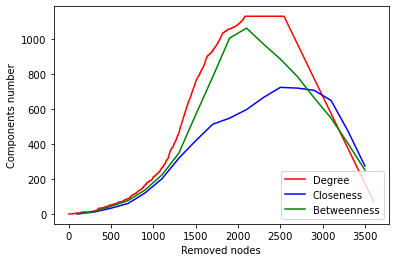

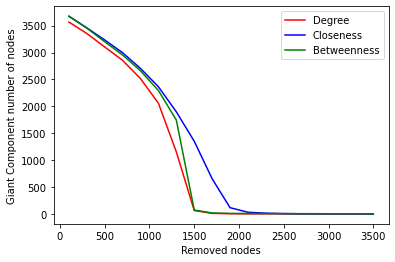

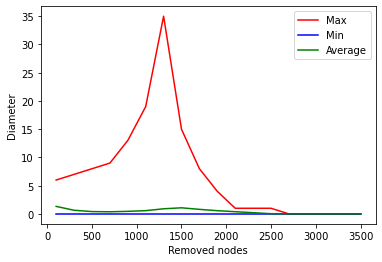

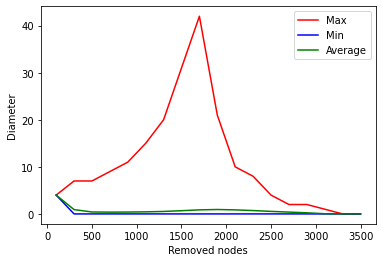

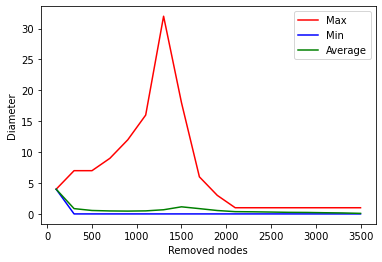

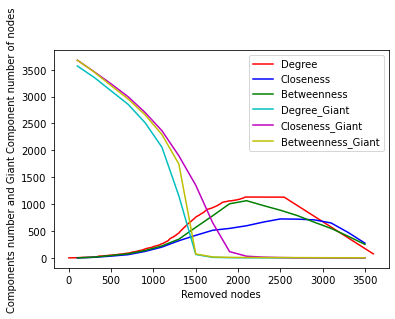

In [258]:
graph_robustness(C1,diametersOn = True)

::: Computing Degree :::

	Node with Max number of Edges:  coronavirus  ||degree 0.7307579748317238

	Node with Max number of Edges:  china  ||degree 0.719847775175644

	Node with Max number of Edges:  virus  ||degree 0.45505124450951684

	Node with Max number of Edges:  outbreak  ||degree 0.45166959578207383

	Node with Max number of Edges:  say  ||degree 0.41048930559624963

	Node with Max number of Edges:  u  ||degree 0.3440797186400938

	Node with Max number of Edges:  new  ||degree 0.34300791556728233

	Node with Max number of Edges:  n  ||degree 0.3334310850439883

	Node with Max number of Edges:  spread  ||degree 0.3074215312408331

	Node with Max number of Edges:  case  ||degree 0.26965962441314556

	Node with Max number of Edges:  people  ||degree 0.26298796595245083

	Node with Max number of Edges:  health  ||degree 0.24104521432765708

	Node with Max number of Edges:  country  ||degree 0.20352422907488987

	Node with Max number of Edges:  city  ||degree 0.2018213866039953

	


	Node with Max number of Edges:  would  ||degree 0.06906997879430475

	Node with Max number of Edges:  find  ||degree 0.06787878787878787

	Node with Max number of Edges:  warn  ||degree 0.06789936344346773

	Node with Max number of Edges:  follow  ||degree 0.06701030927835051

	Node with Max number of Edges:  expert  ||degree 0.0667273278738247

	Node with Max number of Edges:  share  ||degree 0.06674757281553398

	Node with Max number of Edges:  international  ||degree 0.06585735963581184

	Node with Max number of Edges:  come  ||degree 0.06557377049180328

	Node with Max number of Edges:  central  ||degree 0.06529000911023383

	Node with Max number of Edges:  economic  ||degree 0.06500607533414338

	Node with Max number of Edges:  investor  ||degree 0.06472196900638104

	Node with Max number of Edges:  part  ||degree 0.06474164133738602

	Node with Max number of Edges:  trump  ||degree 0.06445728184858619

	Node with Max number of Edges:  early  ||degree 0.0641727493917275

	Node w


	Node with Max number of Edges:  japanese  ||degree 0.03313348059324708

	Node with Max number of Edges:  line  ||degree 0.03282828282828283

	Node with Max number of Edges:  hold  ||degree 0.032207136090937796

	Node with Max number of Edges:  look  ||degree 0.032217308907138344

	Node with Max number of Edges:  panic  ||degree 0.03222748815165877

	Node with Max number of Edges:  airport  ||degree 0.03192161820480405

	Node with Max number of Edges:  avoid  ||degree 0.03193171040151755

	Node with Max number of Edges:  price  ||degree 0.03194180898165718

	Node with Max number of Edges:  general  ||degree 0.03163555836760519

	Node with Max number of Edges:  industry  ||degree 0.03164556962025317

	Node with Max number of Edges:  since  ||degree 0.03165558721114277

	Node with Max number of Edges:  staff  ||degree 0.031665611146295125

	Node with Max number of Edges:  california  ||degree 0.031042128603104215

	Node with Max number of Edges:  cause  ||degree 0.031051964512040557

	N


	Node with Max number of Edges:  claim  ||degree 0.019388761091028592

	Node with Max number of Edges:  ease  ||degree 0.019395134779750165

	Node with Max number of Edges:  pose  ||degree 0.01940151266030911

	Node with Max number of Edges:  revenue  ||degree 0.019407894736842103

	Node with Max number of Edges:  check  ||degree 0.019085225403093122

	Node with Max number of Edges:  five  ||degree 0.019091507570770244

	Node with Max number of Edges:  steal  ||degree 0.019097793875535066

	Node with Max number of Edges:  trial  ||degree 0.019104084321475628

	Node with Max number of Edges:  party  ||degree 0.018780889621087312

	Node with Max number of Edges:  war  ||degree 0.018787079762689517

	Node with Max number of Edges:  affect  ||degree 0.018463567424991757

	Node with Max number of Edges:  couple  ||degree 0.018469656992084433

	Node with Max number of Edges:  daily  ||degree 0.018475750577367205

	Node with Max number of Edges:  limit  ||degree 0.018481848184818482

	Node w


	Node with Max number of Edges:  postpone  ||degree 0.013000342114266164

	Node with Max number of Edges:  pull  ||degree 0.01300479123887748

	Node with Max number of Edges:  recent  ||degree 0.013009243409791166

	Node with Max number of Edges:  screen  ||degree 0.013013698630136987

	Node with Max number of Edges:  surge  ||degree 0.01301815690304899

	Node with Max number of Edges:  transmission  ||degree 0.013022618231665525

	Node with Max number of Edges:  alarm  ||degree 0.012684264655467948
----- Nodes removed:  500  -----

	Node with Max number of Edges:  dow  ||degree 0.012688614540466391

	Node with Max number of Edges:  exclusive  ||degree 0.012692967409948542

	Node with Max number of Edges:  globally  ||degree 0.012697323266986959

	Node with Max number of Edges:  hope  ||degree 0.01270168211465843

	Node with Max number of Edges:  pressure  ||degree 0.012706043956043958

	Node with Max number of Edges:  racism  ||degree 0.012710408794228788

	Node with Max number of Ed


	Node with Max number of Edges:  bat  ||degree 0.008925383791503035

	Node with Max number of Edges:  brace  ||degree 0.008928571428571428

	Node with Max number of Edges:  charge  ||degree 0.008931761343336906

	Node with Max number of Edges:  facebook  ||degree 0.008934953538241601

	Node with Max number of Edges:  fatality  ||degree 0.00893814801573114

	Node with Max number of Edges:  fever  ||degree 0.008941344778254649

	Node with Max number of Edges:  nine  ||degree 0.008944543828264758

	Node with Max number of Edges:  power  ||degree 0.008947745168217608

	Node with Max number of Edges:  practice  ||degree 0.008950948800572862

	Node with Max number of Edges:  problem  ||degree 0.008954154727793696

	Node with Max number of Edges:  rail  ||degree 0.008957362952346828

	Node with Max number of Edges:  reserve  ||degree 0.008960573476702509

	Node with Max number of Edges:  restaurant  ||degree 0.008963786303334529

	Node with Max number of Edges:  rival  ||degree 0.00896700143


	Node with Max number of Edges:  grant  ||degree 0.006711409395973154

	Node with Max number of Edges:  impose  ||degree 0.006713912719134652

	Node with Max number of Edges:  linger  ||degree 0.006716417910447761

	Node with Max number of Edges:  manufacturer  ||degree 0.00671892497200448

	Node with Max number of Edges:  medicine  ||degree 0.006721433905899926

	Node with Max number of Edges:  member  ||degree 0.00672394471423235

	Node with Max number of Edges:  note  ||degree 0.006726457399103139

	Node with Max number of Edges:  popular  ||degree 0.0067289719626168224

	Node with Max number of Edges:  significant  ||degree 0.0067314884068810765

	Node with Max number of Edges:  snake  ||degree 0.006734006734006734

	Node with Max number of Edges:  toward  ||degree 0.006736526946107785

	Node with Max number of Edges:  association  ||degree 0.006364657431673531

	Node with Max number of Edges:  custom  ||degree 0.006367041198501873

	Node with Max number of Edges:  dance  ||degree


	Node with Max number of Edges:  building  ||degree 0.005070202808112325

	Node with Max number of Edges:  burn  ||degree 0.005072181037846274

	Node with Max number of Edges:  cabin  ||degree 0.00507416081186573

	Node with Max number of Edges:  cambodia  ||degree 0.005076142131979696

	Node with Max number of Edges:  catch  ||degree 0.005078125

	Node with Max number of Edges:  conversation  ||degree 0.005080109417741305

	Node with Max number of Edges:  curtail  ||degree 0.0050820953870211105

	Node with Max number of Edges:  democrat  ||degree 0.005084082909659757

	Node with Max number of Edges:  develop  ||degree 0.005086071987480439

	Node with Max number of Edges:  discover  ||degree 0.005088062622309198

	Node with Max number of Edges:  dutch  ||degree 0.005090054815974941

	Node with Max number of Edges:  handle  ||degree 0.0050920485703094395

	Node with Max number of Edges:  hot  ||degree 0.005094043887147335

	Node with Max number of Edges:  however  ||degree 0.0050960407


	Node with Max number of Edges:  feed  ||degree 0.004083299305839118

	Node with Max number of Edges:  feel  ||degree 0.004084967320261438

	Node with Max number of Edges:  hop  ||degree 0.004086636697997548

	Node with Max number of Edges:  isolated  ||degree 0.004088307440719542

	Node with Max number of Edges:  lifeline  ||degree 0.00408997955010225

	Node with Max number of Edges:  location  ||degree 0.004091653027823241

	Node with Max number of Edges:  mean  ||degree 0.004093327875562832

	Node with Max number of Edges:  mild  ||degree 0.004095004095004095

	Node with Max number of Edges:  nightmare  ||degree 0.004096681687832855

	Node with Max number of Edges:  peak  ||degree 0.004098360655737705

	Node with Max number of Edges:  playbook  ||degree 0.004100041000410004

	Node with Max number of Edges:  poise  ||degree 0.004101722723543888

	Node with Max number of Edges:  possibly  ||degree 0.004103405826836274

	Node with Max number of Edges:  precaution  ||degree 0.004105090


	Node with Max number of Edges:  sicken  ||degree 0.003432003432003432

	Node with Max number of Edges:  soap  ||degree 0.0034334763948497852

	Node with Max number of Edges:  sole  ||degree 0.0034349506225848005

	Node with Max number of Edges:  spell  ||degree 0.003436426116838488

	Node with Max number of Edges:  training  ||degree 0.0034379028792436614

	Node with Max number of Edges:  tumble  ||degree 0.0034393809114359416

	Node with Max number of Edges:  unknown  ||degree 0.0034408602150537634

	Node with Max number of Edges:  village  ||degree 0.0034423407917383822

	Node with Max number of Edges:  vote  ||degree 0.0034438226431338786

	Node with Max number of Edges:  within  ||degree 0.0034453057708871662

	Node with Max number of Edges:  actually  ||degree 0.003015941404566997

	Node with Max number of Edges:  ana  ||degree 0.003017241379310345

	Node with Max number of Edges:  approve  ||degree 0.00301854247520483

	Node with Max number of Edges:  bag  ||degree 0.0030198446


	Node with Max number of Edges:  motor  ||degree 0.0027075812274368234

	Node with Max number of Edges:  ping  ||degree 0.002708803611738149

	Node with Max number of Edges:  plead  ||degree 0.0027100271002710027

	Node with Max number of Edges:  plunge  ||degree 0.0027112516945323093

	Node with Max number of Edges:  predict  ||degree 0.0027124773960217

	Node with Max number of Edges:  prepared  ||degree 0.0027137042062415195

	Node with Max number of Edges:  promise  ||degree 0.0027149321266968325

	Node with Max number of Edges:  protester  ||degree 0.002716161158895428

	Node with Max number of Edges:  reopen  ||degree 0.002717391304347826

	Node with Max number of Edges:  revive  ||degree 0.002718622564567286

	Node with Max number of Edges:  roundup  ||degree 0.0027198549410698096

	Node with Max number of Edges:  row  ||degree 0.00272108843537415

	Node with Max number of Edges:  scientific  ||degree 0.0027223230490018148

	Node with Max number of Edges:  seven  ||degree 0.002


	Node with Max number of Edges:  alarming  ||degree 0.0019093078758949881

	Node with Max number of Edges:  answer  ||degree 0.0019102196752626551

	Node with Max number of Edges:  anthem  ||degree 0.0019111323459149545

	Node with Max number of Edges:  apart  ||degree 0.0019120458891013384

	Node with Max number of Edges:  attendant  ||degree 0.001912960306073649

	Node with Max number of Edges:  aviation  ||degree 0.0019138755980861245

	Node with Max number of Edges:  barely  ||degree 0.0019147917663954045

	Node with Max number of Edges:  beef  ||degree 0.0019157088122605363

	Node with Max number of Edges:  belief  ||degree 0.0019166267369429804

	Node with Max number of Edges:  bell  ||degree 0.0019175455417066154

	Node with Max number of Edges:  ben  ||degree 0.0019184652278177458

	Node with Max number of Edges:  breakthrough  ||degree 0.0019193857965451055

	Node with Max number of Edges:  candidate  ||degree 0.0019203072491598655

	Node with Max number of Edges:  celebratio


	Node with Max number of Edges:  swipe  ||degree 0.0020191822311963654

	Node with Max number of Edges:  tan  ||degree 0.00202020202020202

	Node with Max number of Edges:  television  ||degree 0.00202122283981809

	Node with Max number of Edges:  term  ||degree 0.0020222446916076846

	Node with Max number of Edges:  thanks  ||degree 0.0020232675771370764

	Node with Max number of Edges:  tip  ||degree 0.0020242914979757085

	Node with Max number of Edges:  tournament  ||degree 0.0020253164556962027

	Node with Max number of Edges:  trillion  ||degree 0.002026342451874367

	Node with Max number of Edges:  unprecedented  ||degree 0.0020273694880892043

	Node with Max number of Edges:  unrest  ||degree 0.002028397565922921

	Node with Max number of Edges:  upbeat  ||degree 0.0020294266869609334

	Node with Max number of Edges:  vendor  ||degree 0.0020304568527918783

	Node with Max number of Edges:  visa  ||degree 0.002031488065007618

	Node with Max number of Edges:  weather  ||degree 


	Node with Max number of Edges:  jeff  ||degree 0.001610305958132045

	Node with Max number of Edges:  kim  ||degree 0.0016111707841031148

	Node with Max number of Edges:  letter  ||degree 0.0016120365394948952

	Node with Max number of Edges:  leukemia  ||degree 0.0016129032258064516

	Node with Max number of Edges:  love  ||degree 0.001613770844540075

	Node with Max number of Edges:  lower  ||degree 0.0016146393972012916

	Node with Max number of Edges:  macao  ||degree 0.0016155088852988692

	Node with Max number of Edges:  mainstay  ||degree 0.0016163793103448276

	Node with Max number of Edges:  men  ||degree 0.0016172506738544477

	Node with Max number of Edges:  mention  ||degree 0.0016181229773462782

	Node with Max number of Edges:  middle  ||degree 0.0016189962223421479

	Node with Max number of Edges:  monopoly  ||degree 0.0016198704103671706

	Node with Max number of Edges:  mouth  ||degree 0.001620745542949757

	Node with Max number of Edges:  muscle  ||degree 0.0016216


	Node with Max number of Edges:  choke  ||degree 0.0011448196908986834

	Node with Max number of Edges:  chronic  ||degree 0.001145475372279496

	Node with Max number of Edges:  clash  ||degree 0.001146131805157593

	Node with Max number of Edges:  clue  ||degree 0.0011467889908256881

	Node with Max number of Edges:  cobalt  ||degree 0.0011474469305794606

	Node with Max number of Edges:  collapse  ||degree 0.001148105625717566

	Node with Max number of Edges:  comment  ||degree 0.0011487650775416428

	Node with Max number of Edges:  commercial  ||degree 0.0011494252873563218

	Node with Max number of Edges:  confederation  ||degree 0.0011500862564692352

	Node with Max number of Edges:  conflict  ||degree 0.0011507479861910242

	Node with Max number of Edges:  conflicting  ||degree 0.0011514104778353484

	Node with Max number of Edges:  contamination  ||degree 0.001152073732718894

	Node with Max number of Edges:  contest  ||degree 0.0011527377521613833

	Node with Max number of Edg


	Node with Max number of Edges:  metropolis  ||degree 0.0012277470841006752

	Node with Max number of Edges:  name  ||degree 0.0012285012285012285

	Node with Max number of Edges:  nausea  ||degree 0.001229256299938537

	Node with Max number of Edges:  necessary  ||degree 0.0012300123001230013

	Node with Max number of Edges:  nest  ||degree 0.0012307692307692308

	Node with Max number of Edges:  nonessential  ||degree 0.0012315270935960591

	Node with Max number of Edges:  ordinary  ||degree 0.0012322858903265558

	Node with Max number of Edges:  overall  ||degree 0.0012330456226880395

	Node with Max number of Edges:  particular  ||degree 0.0012338062924120913

	Node with Max number of Edges:  passport  ||degree 0.0012345679012345679

	Node with Max number of Edges:  percentage  ||degree 0.0012353304508956147

	Node with Max number of Edges:  performance  ||degree 0.0012360939431396785

	Node with Max number of Edges:  pervasive  ||degree 0.0012368583797155227

	Node with Max number


	Node with Max number of Edges:  bogus  ||degree 0.0006596306068601583

	Node with Max number of Edges:  bolster  ||degree 0.0006600660066006601

	Node with Max number of Edges:  boom  ||degree 0.0006605019815059445

	Node with Max number of Edges:  bottle  ||degree 0.0006609385327164573

	Node with Max number of Edges:  bottom  ||degree 0.0006613756613756613

	Node with Max number of Edges:  bounce  ||degree 0.0006618133686300463

	Node with Max number of Edges:  bound  ||degree 0.0006622516556291391

	Node with Max number of Edges:  breach  ||degree 0.0006626905235255136

	Node with Max number of Edges:  breathing  ||degree 0.000663129973474801

	Node with Max number of Edges:  brent  ||degree 0.0006635700066357001

	Node with Max number of Edges:  broaden  ||degree 0.0006640106241699867

	Node with Max number of Edges:  browsing  ||degree 0.000664451827242525

	Node with Max number of Edges:  brunt  ||degree 0.0006648936170212766

	Node with Max number of Edges:  brutal  ||degree 0


	Node with Max number of Edges:  eating  ||degree 0.0007132667617689016

	Node with Max number of Edges:  economics  ||degree 0.0007137758743754461

	Node with Max number of Edges:  edition  ||degree 0.0007142857142857143

	Node with Max number of Edges:  eerily  ||degree 0.0007147962830593281

	Node with Max number of Edges:  effective  ||degree 0.000715307582260372

	Node with Max number of Edges:  egg  ||degree 0.0007158196134574087

	Node with Max number of Edges:  either  ||degree 0.0007163323782234957

	Node with Max number of Edges:  electronic  ||degree 0.0007168458781362007

	Node with Max number of Edges:  elevated  ||degree 0.0007173601147776184

	Node with Max number of Edges:  eliminate  ||degree 0.0007178750897343862

	Node with Max number of Edges:  elusive  ||degree 0.0007183908045977011

	Node with Max number of Edges:  emit  ||degree 0.0007189072609633358

	Node with Max number of Edges:  endure  ||degree 0.0007194244604316547

	Node with Max number of Edges:  enough


	Node with Max number of Edges:  itinerary  ||degree 0.000774593338497289

	Node with Max number of Edges:  juncture  ||degree 0.0007751937984496124

	Node with Max number of Edges:  jury  ||degree 0.0007757951900698216

	Node with Max number of Edges:  lady  ||degree 0.0007763975155279503

	Node with Max number of Edges:  lauder  ||degree 0.000777000777000777

	Node with Max number of Edges:  legend  ||degree 0.0007776049766718507

	Node with Max number of Edges:  lender  ||degree 0.0007782101167315176

	Node with Max number of Edges:  lethal  ||degree 0.000778816199376947

	Node with Max number of Edges:  lifeblood  ||degree 0.000779423226812159

	Node with Max number of Edges:  limited  ||degree 0.00078003120124805

	Node with Max number of Edges:  limp  ||degree 0.00078064012490242

	Node with Max number of Edges:  locked  ||degree 0.00078125

	Node with Max number of Edges:  logistics  ||degree 0.0007818608287724785

	Node with Max number of Edges:  lunch  ||degree 0.000782472613


	Node with Max number of Edges:  rout  ||degree 0.000851063829787234

	Node with Max number of Edges:  runny  ||degree 0.0008517887563884157

	Node with Max number of Edges:  rusty  ||degree 0.0008525149190110827

	Node with Max number of Edges:  scan  ||degree 0.0008532423208191126

	Node with Max number of Edges:  scar  ||degree 0.0008539709649871904

	Node with Max number of Edges:  score  ||degree 0.0008547008547008547

	Node with Max number of Edges:  scout  ||degree 0.000855431993156544

	Node with Max number of Edges:  scrutiny  ||degree 0.0008561643835616438

	Node with Max number of Edges:  section  ||degree 0.000856898029134533

	Node with Max number of Edges:  self  ||degree 0.0008576329331046312

	Node with Max number of Edges:  seller  ||degree 0.0008583690987124463

	Node with Max number of Edges:  sense  ||degree 0.000859106529209622

	Node with Max number of Edges:  session  ||degree 0.0008598452278589854

	Node with Max number of Edges:  sexy  ||degree 0.0008605851979


	Node with Max number of Edges:  borrow  ||degree 0.0

	Node with Max number of Edges:  bosch  ||degree 0.0

	Node with Max number of Edges:  bouquet  ||degree 0.0

	Node with Max number of Edges:  branch  ||degree 0.0

	Node with Max number of Edges:  breakdown  ||degree 0.0

	Node with Max number of Edges:  bridge  ||degree 0.0

	Node with Max number of Edges:  briefing  ||degree 0.0

	Node with Max number of Edges:  brink  ||degree 0.0

	Node with Max number of Edges:  broke  ||degree 0.0

	Node with Max number of Edges:  burden  ||degree 0.0

	Node with Max number of Edges:  bureau  ||degree 0.0

	Node with Max number of Edges:  bureaucrat  ||degree 0.0

	Node with Max number of Edges:  ca  ||degree 0.0

	Node with Max number of Edges:  cabinet  ||degree 0.0

	Node with Max number of Edges:  campus  ||degree 0.0

	Node with Max number of Edges:  canary  ||degree 0.0

	Node with Max number of Edges:  cancer  ||degree 0.0

	Node with Max number of Edges:  candle  ||degree 0.0

	Node


	Node with Max number of Edges:  edgy  ||degree 0.0

	Node with Max number of Edges:  editor  ||degree 0.0

	Node with Max number of Edges:  eighth  ||degree 0.0

	Node with Max number of Edges:  el  ||degree 0.0

	Node with Max number of Edges:  electric  ||degree 0.0

	Node with Max number of Edges:  elephant  ||degree 0.0

	Node with Max number of Edges:  elevate  ||degree 0.0

	Node with Max number of Edges:  eleven  ||degree 0.0

	Node with Max number of Edges:  eligible  ||degree 0.0

	Node with Max number of Edges:  elite  ||degree 0.0

	Node with Max number of Edges:  embattle  ||degree 0.0

	Node with Max number of Edges:  enact  ||degree 0.0

	Node with Max number of Edges:  encompass  ||degree 0.0

	Node with Max number of Edges:  endeavor  ||degree 0.0

	Node with Max number of Edges:  enforcement  ||degree 0.0

	Node with Max number of Edges:  engage  ||degree 0.0

	Node with Max number of Edges:  engagement  ||degree 0.0

	Node with Max number of Edges:  enormous  ||degr


	Node with Max number of Edges:  immigrant  ||degree 0.0

	Node with Max number of Edges:  immigration  ||degree 0.0

	Node with Max number of Edges:  immune  ||degree 0.0

	Node with Max number of Edges:  imperial  ||degree 0.0

	Node with Max number of Edges:  implication  ||degree 0.0

	Node with Max number of Edges:  impossible  ||degree 0.0

	Node with Max number of Edges:  impressive  ||degree 0.0

	Node with Max number of Edges:  inadvertently  ||degree 0.0

	Node with Max number of Edges:  inanimate  ||degree 0.0

	Node with Max number of Edges:  inappropriate  ||degree 0.0

	Node with Max number of Edges:  inappropriately  ||degree 0.0

	Node with Max number of Edges:  inbound  ||degree 0.0

	Node with Max number of Edges:  inclusion  ||degree 0.0

	Node with Max number of Edges:  incorrectly  ||degree 0.0

	Node with Max number of Edges:  increasingly  ||degree 0.0

	Node with Max number of Edges:  incredibly  ||degree 0.0

	Node with Max number of Edges:  incur  ||degree 0.


	Node with Max number of Edges:  neglect  ||degree 0.0

	Node with Max number of Edges:  nerve  ||degree 0.0

	Node with Max number of Edges:  nervous  ||degree 0.0

	Node with Max number of Edges:  nestle  ||degree 0.0

	Node with Max number of Edges:  nick  ||degree 0.0

	Node with Max number of Edges:  nonly  ||degree 0.0

	Node with Max number of Edges:  notable  ||degree 0.0

	Node with Max number of Edges:  notch  ||degree 0.0

	Node with Max number of Edges:  noted  ||degree 0.0

	Node with Max number of Edges:  nothing  ||degree 0.0

	Node with Max number of Edges:  noticeably  ||degree 0.0

	Node with Max number of Edges:  nowhere  ||degree 0.0

	Node with Max number of Edges:  nuclear  ||degree 0.0

	Node with Max number of Edges:  obligation  ||degree 0.0

	Node with Max number of Edges:  observation  ||degree 0.0

	Node with Max number of Edges:  obsession  ||degree 0.0

	Node with Max number of Edges:  ocean  ||degree 0.0

	Node with Max number of Edges:  oculus  ||degree


	Node with Max number of Edges:  recrimination  ||degree 0.0

	Node with Max number of Edges:  recruit  ||degree 0.0

	Node with Max number of Edges:  recruitment  ||degree 0.0

	Node with Max number of Edges:  refine  ||degree 0.0

	Node with Max number of Edges:  refinery  ||degree 0.0

	Node with Max number of Edges:  refining  ||degree 0.0

	Node with Max number of Edges:  refit  ||degree 0.0

	Node with Max number of Edges:  refuel  ||degree 0.0

	Node with Max number of Edges:  refugee  ||degree 0.0

	Node with Max number of Edges:  refuse  ||degree 0.0

	Node with Max number of Edges:  regret  ||degree 0.0

	Node with Max number of Edges:  regularly  ||degree 0.0

	Node with Max number of Edges:  regulator  ||degree 0.0

	Node with Max number of Edges:  rein  ||degree 0.0

	Node with Max number of Edges:  relationship  ||degree 0.0

	Node with Max number of Edges:  relatively  ||degree 0.0

	Node with Max number of Edges:  relaxation  ||degree 0.0

	Node with Max number of Edge


	Node with Max number of Edges:  sport  ||degree 0.0

	Node with Max number of Edges:  spot  ||degree 0.0

	Node with Max number of Edges:  spreader  ||degree 0.0

	Node with Max number of Edges:  spurt  ||degree 0.0

	Node with Max number of Edges:  spy  ||degree 0.0

	Node with Max number of Edges:  squabble  ||degree 0.0

	Node with Max number of Edges:  sri  ||degree 0.0

	Node with Max number of Edges:  stability  ||degree 0.0

	Node with Max number of Edges:  stabilize  ||degree 0.0

	Node with Max number of Edges:  stable  ||degree 0.0

	Node with Max number of Edges:  stack  ||degree 0.0

	Node with Max number of Edges:  stadium  ||degree 0.0

	Node with Max number of Edges:  stage  ||degree 0.0

	Node with Max number of Edges:  stall  ||degree 0.0

	Node with Max number of Edges:  standard  ||degree 0.0

	Node with Max number of Edges:  starve  ||degree 0.0

	Node with Max number of Edges:  status  ||degree 0.0

	Node with Max number of Edges:  stave  ||degree 0.0

	Node with


	Node with Max number of Edges:  unexpected  ||degree 0.0

	Node with Max number of Edges:  unexpectedly  ||degree 0.0

	Node with Max number of Edges:  unforgivable  ||degree 0.0

	Node with Max number of Edges:  unhappiness  ||degree 0.0
----- Nodes removed:  3300  -----

	Node with Max number of Edges:  unhygienic  ||degree 0.0

	Node with Max number of Edges:  unified  ||degree 0.0

	Node with Max number of Edges:  unit  ||degree 0.0

	Node with Max number of Edges:  unite  ||degree 0.0

	Node with Max number of Edges:  unknowingly  ||degree 0.0

	Node with Max number of Edges:  unless  ||degree 0.0

	Node with Max number of Edges:  unlike  ||degree 0.0

	Node with Max number of Edges:  unlikely  ||degree 0.0

	Node with Max number of Edges:  unofficially  ||degree 0.0

	Node with Max number of Edges:  unorthodox  ||degree 0.0

	Node with Max number of Edges:  unproven  ||degree 0.0

	Node with Max number of Edges:  unpublished  ||degree 0.0

	Node with Max number of Edges:  unsol

----- Nodes removed:  15  -----

	Node with Max number of Edges:  funnel  ||closeness 0.0
----- Nodes removed:  16  -----

	Node with Max number of Edges:  prop  ||closeness 0.0
::: Computing Betweenness :::
----- Nodes removed:  0  -----

	Node with Max number of Edges:  coronavirus  ||betweenness 0.2111807559921878
----- Nodes removed:  1  -----

	Node with Max number of Edges:  epicenter  ||betweenness 0.013534898202301724
----- Nodes removed:  2  -----

	Node with Max number of Edges:  surgical  ||betweenness 0.010753544025892327
----- Nodes removed:  3  -----

	Node with Max number of Edges:  tonight  ||betweenness 0.012625805674922747
----- Nodes removed:  4  -----

	Node with Max number of Edges:  attempt  ||betweenness 0.018014990745966002
----- Nodes removed:  5  -----

	Node with Max number of Edges:  determine  ||betweenness 0.045612248442178586
----- Nodes removed:  6  -----

	Node with Max number of Edges:  silence  ||betweenness 0.01946885650592973
----- Nodes removed:  7

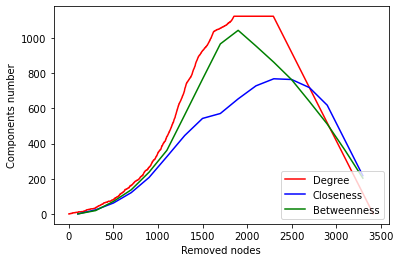

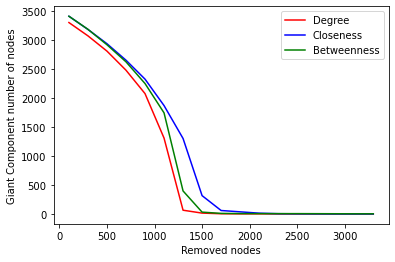

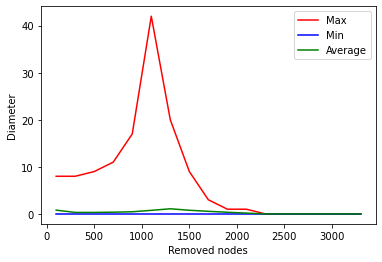

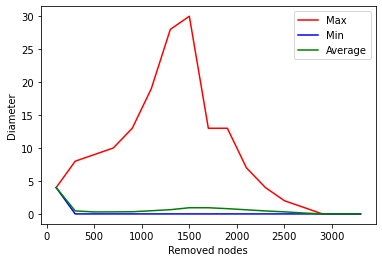

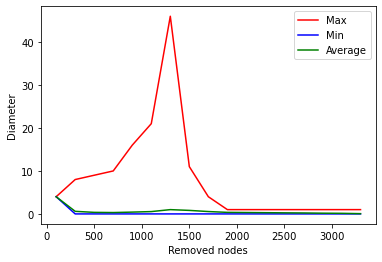

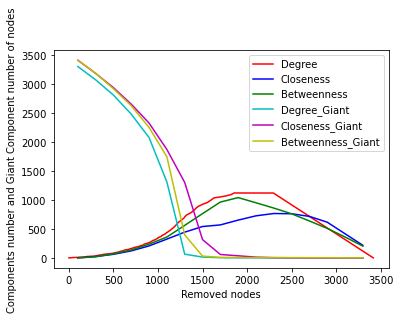

In [267]:
graph_robustness(A1,diametersOn = True)

::: Computing Degree :::

	Node with Max number of Edges:  china  ||degree 0.7670494492617764

	Node with Max number of Edges:  n  ||degree 0.4092827004219409

	Node with Max number of Edges:  say  ||degree 0.388042203985932

	Node with Max number of Edges:  covid  ||degree 0.3646810506566604

	Node with Max number of Edges:  u  ||degree 0.2983814215341309

	Node with Max number of Edges:  year  ||degree 0.2700610042233693

	Node with Max number of Edges:  country  ||degree 0.2576859892044121

	Node with Max number of Edges:  people  ||degree 0.24553990610328638

	Node with Max number of Edges:  new  ||degree 0.24231040150270017

	Node with Max number of Edges:  province  ||degree 0.2383748238609676

	Node with Max number of Edges:  world  ||degree 0.2374911909795631

	Node with Max number of Edges:  city  ||degree 0.2319078947368421

	Node with Max number of Edges:  president  ||degree 0.22115158636897767

	Node with Max number of Edges:  pandemic  ||degree 0.21227080394922423

	Node 


	Node with Max number of Edges:  promote  ||degree 0.06506024096385542

	Node with Max number of Edges:  epidemic  ||degree 0.06459387804290191

	Node with Max number of Edges:  company  ||degree 0.06412729026036644

	Node with Max number of Edges:  growth  ||degree 0.06390161562575356

	Node with Max number of Edges:  top  ||degree 0.0639170284611674

	Node with Max number of Edges:  festival  ||degree 0.06296743063932449

	Node with Max number of Edges:  mid  ||degree 0.0625

	Node with Max number of Edges:  click  ||degree 0.06203234371228578

	Node with Max number of Edges:  continue  ||degree 0.061564461612747465

	Node with Max number of Edges:  minister  ||degree 0.06133784110118329

	Node with Max number of Edges:  end  ||degree 0.06111111111111111

	Node with Max number of Edges:  business  ||degree 0.06088427156317951

	Node with Max number of Edges:  could  ||degree 0.06041565973900435

	Node with Max number of Edges:  include  ||degree 0.06043026347594876

	Node with Max n


	Node with Max number of Edges:  remain  ||degree 0.03818497396479048

	Node with Max number of Edges:  stop  ||degree 0.03794642857142857

	Node with Max number of Edges:  confirm  ||degree 0.03745968742247581

	Node with Max number of Edges:  security  ||degree 0.03746898263027295

	Node with Max number of Edges:  place  ||degree 0.036733680814097794

	Node with Max number of Edges:  shenzhen  ||degree 0.036742800397219465

	Node with Max number of Edges:  water  ||degree 0.03675192450956047

	Node with Max number of Edges:  post  ||degree 0.03651266766020864

	Node with Max number of Edges:  history  ||degree 0.03627329192546584

	Node with Max number of Edges:  right  ||degree 0.036033797216699796

	Node with Max number of Edges:  guangdong  ||degree 0.035794183445190156

	Node with Max number of Edges:  railway  ||degree 0.03555445052212829

	Node with Max number of Edges:  technology  ||degree 0.03556329271325541

	Node with Max number of Edges:  among  ||degree 0.03507462686567


	Node with Max number of Edges:  mask  ||degree 0.02376693074367493

	Node with Max number of Edges:  meeting  ||degree 0.023773006134969327

	Node with Max number of Edges:  passenger  ||degree 0.02377908463308617

	Node with Max number of Edges:  accusation  ||degree 0.023529411764705882

	Node with Max number of Edges:  ethnic  ||degree 0.0235354310565362

	Node with Max number of Edges:  expand  ||degree 0.02354145342886387

	Node with Max number of Edges:  park  ||degree 0.02354747888405426

	Node with Max number of Edges:  alleviation  ||degree 0.023297491039426525

	Node with Max number of Edges:  let  ||degree 0.023303457106274007

	Node with Max number of Edges:  production  ||degree 0.0233094262295082

	Node with Max number of Edges:  restriction  ||degree 0.02331539841147835

	Node with Max number of Edges:  trial  ||degree 0.023321373654536133

	Node with Max number of Edges:  farmer  ||degree 0.023071007433991285

	Node with Max number of Edges:  rule  ||degree 0.02307692


	Node with Max number of Edges:  meet  ||degree 0.016886543535620052

	Node with Max number of Edges:  must  ||degree 0.01689100026392188

	Node with Max number of Edges:  p  ||degree 0.01689545934530095

	Node with Max number of Edges:  serve  ||degree 0.016899920781621336

	Node with Max number of Edges:  upcoming  ||degree 0.016904384574749076

	Node with Max number of Edges:  value  ||degree 0.01690885072655218

	Node with Max number of Edges:  zone  ||degree 0.016913319238900635

	Node with Max number of Edges:  even  ||degree 0.016653449643140365

	Node with Max number of Edges:  family  ||degree 0.016657852987837122

	Node with Max number of Edges:  hand  ||degree 0.0166622586617297

	Node with Max number of Edges:  never  ||degree 0.016666666666666666

	Node with Max number of Edges:  population  ||degree 0.016671077004498543

	Node with Max number of Edges:  prefecture  ||degree 0.01667548967707782

	Node with Max number of Edges:  scenery  ||degree 0.016679904686258937

	Nod


	Node with Max number of Edges:  jointly  ||degree 0.013057671381936888

	Node with Max number of Edges:  living  ||degree 0.013061224489795919

	Node with Max number of Edges:  policy  ||degree 0.013064779531845401

	Node with Max number of Edges:  rate  ||degree 0.013068336509665124

	Node with Max number of Edges:  trip  ||degree 0.013071895424836603

	Node with Max number of Edges:  different  ||degree 0.01280305093979842

	Node with Max number of Edges:  happen  ||degree 0.012806539509536785

	Node with Max number of Edges:  italy  ||degree 0.012810029980921232

	Node with Max number of Edges:  li  ||degree 0.012813522355507088

	Node with Max number of Edges:  neutrality  ||degree 0.012817016634851377

	Node with Max number of Edges:  outside  ||degree 0.01282051282051282

	Node with Max number of Edges:  tech  ||degree 0.012824010914051843

	Node with Max number of Edges:  address  ||degree 0.012554585152838428

	Node with Max number of Edges:  aerial  ||degree 0.01255801255801


	Node with Max number of Edges:  councilor  ||degree 0.009572072072072071

	Node with Max number of Edges:  driver  ||degree 0.009574767671078569

	Node with Max number of Edges:  gas  ||degree 0.009577464788732394

	Node with Max number of Edges:  order  ||degree 0.009580163426317272

	Node with Max number of Edges:  restaurant  ||degree 0.009582863585118376

	Node with Max number of Edges:  save  ||degree 0.00958556526642233

	Node with Max number of Edges:  animation  ||degree 0.00930626057529611

	Node with Max number of Edges:  cancel  ||degree 0.00930888575458392

	Node with Max number of Edges:  clear  ||degree 0.009311512415349886

	Node with Max number of Edges:  commerce  ||degree 0.009314140558848433

	Node with Max number of Edges:  elderly  ||degree 0.009316770186335404

	Node with Max number of Edges:  enterprise  ||degree 0.00931940129906806

	Node with Max number of Edges:  every  ||degree 0.009322033898305085

	Node with Max number of Edges:  financial  ||degree 0.009


	Node with Max number of Edges:  eliminate  ||degree 0.007299270072992701

	Node with Max number of Edges:  grassland  ||degree 0.007301401869158878

	Node with Max number of Edges:  kit  ||degree 0.007303534910896874

	Node with Max number of Edges:  later  ||degree 0.007305669199298656

	Node with Max number of Edges:  literally  ||degree 0.007307804735457469

	Node with Max number of Edges:  little  ||degree 0.007309941520467837

	Node with Max number of Edges:  movie  ||degree 0.007312079555425563

	Node with Max number of Edges:  respect  ||degree 0.007314218841427736

	Node with Max number of Edges:  rest  ||degree 0.0073163593795727245

	Node with Max number of Edges:  satellite  ||degree 0.007318501170960188

	Node with Max number of Edges:  series  ||degree 0.007320644216691069

	Node with Max number of Edges:  attack  ||degree 0.007029876977152899

	Node with Max number of Edges:  deepen  ||degree 0.0070319367125695875

	Node with Max number of Edges:  department  ||degree 0


	Node with Max number of Edges:  ability  ||degree 0.005748865355521936

	Node with Max number of Edges:  attention  ||degree 0.0057506053268765135

	Node with Max number of Edges:  clinical  ||degree 0.005752346351801392

	Node with Max number of Edges:  employee  ||degree 0.005754088431253785

	Node with Max number of Edges:  era  ||degree 0.005755831566192063

	Node with Max number of Edges:  football  ||degree 0.005757575757575757

	Node with Max number of Edges:  fu  ||degree 0.005759321006365566

	Node with Max number of Edges:  globally  ||degree 0.005761067313523348

	Node with Max number of Edges:  kick  ||degree 0.005762814680012132

	Node with Max number of Edges:  list  ||degree 0.005764563106796116

	Node with Max number of Edges:  luxury  ||degree 0.005766312594840668

	Node with Max number of Edges:  magnificent  ||degree 0.005768063145112326

	Node with Max number of Edges:  manage  ||degree 0.005769814758578804

	Node with Max number of Edges:  minority  ||degree 0.00


	Node with Max number of Edges:  effect  ||degree 0.004708097928436912

	Node with Max number of Edges:  equipment  ||degree 0.004709576138147567

	Node with Max number of Edges:  footage  ||degree 0.00471105527638191

	Node with Max number of Edges:  founder  ||degree 0.00471253534401508

	Node with Max number of Edges:  france  ||degree 0.004714016341923319

	Node with Max number of Edges:  fully  ||degree 0.004715498270983967

	Node with Max number of Edges:  interest  ||degree 0.0047169811320754715

	Node with Max number of Edges:  male  ||degree 0.004718464926077383

	Node with Max number of Edges:  perform  ||degree 0.004719949653870359

	Node with Max number of Edges:  price  ||degree 0.004721435316336166

	Node with Max number of Edges:  process  ||degree 0.004722921914357682

	Node with Max number of Edges:  regulation  ||degree 0.004724409448818898

	Node with Max number of Edges:  sight  ||degree 0.004725897920604915

	Node with Max number of Edges:  significantly  ||degree


	Node with Max number of Edges:  enough  ||degree 0.003911342894393741

	Node with Max number of Edges:  exhibition  ||degree 0.0039126181936746

	Node with Max number of Edges:  expansion  ||degree 0.003913894324853229

	Node with Max number of Edges:  exporter  ||degree 0.003915171288743882

	Node with Max number of Edges:  fan  ||degree 0.00391644908616188

	Node with Max number of Edges:  father  ||degree 0.0039177277179236044

	Node with Max number of Edges:  fit  ||degree 0.003919007184846506

	Node with Max number of Edges:  isolated  ||degree 0.003920287487749101

	Node with Max number of Edges:  kilometer  ||degree 0.00392156862745098

	Node with Max number of Edges:  load  ||degree 0.003922850604772802

	Node with Max number of Edges:  lunar  ||degree 0.003924133420536298

	Node with Max number of Edges:  maker  ||degree 0.003925417075564279

	Node with Max number of Edges:  nuclear  ||degree 0.003926701570680629

	Node with Max number of Edges:  panel  ||degree 0.0039279869


	Node with Max number of Edges:  officially  ||degree 0.003382949932341002

	Node with Max number of Edges:  output  ||degree 0.00338409475465313

	Node with Max number of Edges:  penny  ||degree 0.0033852403520649964

	Node with Max number of Edges:  rail  ||degree 0.003386386725364037

	Node with Max number of Edges:  resist  ||degree 0.0033875338753387536

	Node with Max number of Edges:  session  ||degree 0.0033886818027787195

	Node with Max number of Edges:  single  ||degree 0.0033898305084745766

	Node with Max number of Edges:  solar  ||degree 0.0033909799932180405

	Node with Max number of Edges:  speak  ||degree 0.0033921302578018993

	Node with Max number of Edges:  steal  ||degree 0.0033932813030200207

	Node with Max number of Edges:  steam  ||degree 0.0033944331296673455

	Node with Max number of Edges:  surround  ||degree 0.003395585738539898

	Node with Max number of Edges:  survey  ||degree 0.0033967391304347825

	Node with Max number of Edges:  tall  ||degree 0.00339


	Node with Max number of Edges:  explosion  ||degree 0.0028159098908834917

	Node with Max number of Edges:  feat  ||degree 0.0028169014084507044

	Node with Max number of Edges:  fee  ||degree 0.0028178936245156746

	Node with Max number of Edges:  fleet  ||degree 0.0028188865398167725

	Node with Max number of Edges:  german  ||degree 0.0028198801550934085

	Node with Max number of Edges:  glacier  ||degree 0.0028208744710860366

	Node with Max number of Edges:  guard  ||degree 0.0028218694885361554

	Node with Max number of Edges:  height  ||degree 0.0028228652081863093

	Node with Max number of Edges:  hick  ||degree 0.0028238616307800918

	Node with Max number of Edges:  idea  ||degree 0.002824858757062147

	Node with Max number of Edges:  image  ||degree 0.00282585658777817

	Node with Max number of Edges:  interaction  ||degree 0.0028268551236749115

	Node with Max number of Edges:  iran  ||degree 0.002827854365500177

	Node with Max number of Edges:  kamala  ||degree 0.0028288


	Node with Max number of Edges:  phone  ||degree 0.002568807339449541

	Node with Max number of Edges:  plus  ||degree 0.0025697503671071953

	Node with Max number of Edges:  premier  ||degree 0.002570694087403599

	Node with Max number of Edges:  prosperity  ||degree 0.0025716385011021305

	Node with Max number of Edges:  ravage  ||degree 0.0025725836089672918

	Node with Max number of Edges:  resort  ||degree 0.002573529411764706

	Node with Max number of Edges:  serious  ||degree 0.0025744759102611257

	Node with Max number of Edges:  shroud  ||degree 0.0025754231052244297

	Node with Max number of Edges:  singapore  ||degree 0.002576370997423629

	Node with Max number of Edges:  situate  ||degree 0.002577319587628866

	Node with Max number of Edges:  sized  ||degree 0.002578268876611418

	Node with Max number of Edges:  star  ||degree 0.002579218865143699

	Node with Max number of Edges:  strain  ||degree 0.002580169553999263

	Node with Max number of Edges:  strongly  ||degree 0.


	Node with Max number of Edges:  shot  ||degree 0.0023014959723820483

	Node with Max number of Edges:  sleeve  ||degree 0.0023023791250959325

	Node with Max number of Edges:  sprout  ||degree 0.0023032629558541267

	Node with Max number of Edges:  strategic  ||degree 0.002304147465437788

	Node with Max number of Edges:  stretch  ||degree 0.002305032654629274

	Node with Max number of Edges:  string  ||degree 0.0023059185242121447

	Node with Max number of Edges:  terrain  ||degree 0.002306805074971165

	Node with Max number of Edges:  thorough  ||degree 0.0023076923076923075

	Node with Max number of Edges:  troop  ||degree 0.002308580223162755

	Node with Max number of Edges:  undermine  ||degree 0.0023094688221709007

	Node with Max number of Edges:  unearth  ||degree 0.0023103581055063534

	Node with Max number of Edges:  unilateral  ||degree 0.0023112480739599386

	Node with Max number of Edges:  union  ||degree 0.0023121387283236996

	Node with Max number of Edges:  unit  ||de


	Node with Max number of Edges:  robust  ||degree 0.002005615724027276

	Node with Max number of Edges:  scale  ||degree 0.0020064205457463883

	Node with Max number of Edges:  screen  ||degree 0.002007226013649137

	Node with Max number of Edges:  seventh  ||degree 0.0020080321285140565

	Node with Max number of Edges:  sexual  ||degree 0.002008838891120932

	Node with Max number of Edges:  slam  ||degree 0.0020096463022508037

	Node with Max number of Edges:  sniff  ||degree 0.002010454362685967

	Node with Max number of Edges:  snowfall  ||degree 0.0020112630732099755

	Node with Max number of Edges:  song  ||degree 0.002012072434607646

	Node with Max number of Edges:  spotlight  ||degree 0.002012882447665056

	Node with Max number of Edges:  stamp  ||degree 0.002013693113169553

	Node with Max number of Edges:  submersible  ||degree 0.00201450443190975

	Node with Max number of Edges:  sudden  ||degree 0.002015316404675534

	Node with Max number of Edges:  sunrise  ||degree 0.002


	Node with Max number of Edges:  nick  ||degree 0.0016806722689075631

	Node with Max number of Edges:  officer  ||degree 0.0016813787305590584

	Node with Max number of Edges:  opening  ||degree 0.001682085786375105

	Node with Max number of Edges:  outfit  ||degree 0.0016827934371055953

	Node with Max number of Edges:  passion  ||degree 0.0016835016835016834

	Node with Max number of Edges:  pasture  ||degree 0.0016842105263157896

	Node with Max number of Edges:  pear  ||degree 0.0016849199663016006

	Node with Max number of Edges:  pharmacy  ||degree 0.001685630004214075

	Node with Max number of Edges:  physical  ||degree 0.0016863406408094434

	Node with Max number of Edges:  pit  ||degree 0.001687051876845213

	Node with Max number of Edges:  preliminary  ||degree 0.0016877637130801688

	Node with Max number of Edges:  previous  ||degree 0.0016884761502743773

	Node with Max number of Edges:  protectionism  ||degree 0.0016891891891891893

	Node with Max number of Edges:  prote


	Node with Max number of Edges:  dead  ||degree 0.001323918799646955

	Node with Max number of Edges:  deaf  ||degree 0.0013245033112582781

	Node with Max number of Edges:  deceit  ||degree 0.0013250883392226147

	Node with Max number of Edges:  declare  ||degree 0.0013256738842244808

	Node with Max number of Edges:  decommission  ||degree 0.001326259946949602

	Node with Max number of Edges:  decorate  ||degree 0.0013268465280849183

	Node with Max number of Edges:  decoration  ||degree 0.001327433628318584

	Node with Max number of Edges:  decrease  ||degree 0.0013280212483399736

	Node with Max number of Edges:  deed  ||degree 0.001328609388839681

	Node with Max number of Edges:  degree  ||degree 0.001329198050509526

	Node with Max number of Edges:  deployment  ||degree 0.0013297872340425532

	Node with Max number of Edges:  detain  ||degree 0.0013303769401330377

	Node with Max number of Edges:  dialogue  ||degree 0.0013309671694764864

	Node with Max number of Edges:  difficu


	Node with Max number of Edges:  sense  ||degree 0.001392757660167131

	Node with Max number of Edges:  shopper  ||degree 0.0013934045517882026

	Node with Max number of Edges:  silk  ||degree 0.0013940520446096654

	Node with Max number of Edges:  solemn  ||degree 0.001394700139470014

	Node with Max number of Edges:  solve  ||degree 0.0013953488372093023

	Node with Max number of Edges:  sort  ||degree 0.0013959981386691485

	Node with Max number of Edges:  speaker  ||degree 0.0013966480446927375

	Node with Max number of Edges:  spectator  ||degree 0.0013972985561248254

	Node with Max number of Edges:  stable  ||degree 0.0013979496738117428

	Node with Max number of Edges:  standing  ||degree 0.0013986013986013986

	Node with Max number of Edges:  status  ||degree 0.0013992537313432835

	Node with Max number of Edges:  stimulate  ||degree 0.0013999066728884741

	Node with Max number of Edges:  straw  ||degree 0.0014005602240896359

	Node with Max number of Edges:  streaming  ||deg


	Node with Max number of Edges:  colleague  ||degree 0.000980392156862745

	Node with Max number of Edges:  collector  ||degree 0.000980872976949485

	Node with Max number of Edges:  collide  ||degree 0.0009813542688910696

	Node with Max number of Edges:  commander  ||degree 0.0009818360333824251

	Node with Max number of Edges:  commence  ||degree 0.0009823182711198428

	Node with Max number of Edges:  commencement  ||degree 0.0009828009828009828

	Node with Max number of Edges:  commensurate  ||degree 0.0009832841691248771

	Node with Max number of Edges:  commentary  ||degree 0.000983767830791933

	Node with Max number of Edges:  comparison  ||degree 0.000984251968503937

	Node with Max number of Edges:  competency  ||degree 0.0009847365829640572

	Node with Max number of Edges:  congenitally  ||degree 0.0009852216748768472

	Node with Max number of Edges:  congress  ||degree 0.0009857072449482504

	Node with Max number of Edges:  conjugal  ||degree 0.0009861932938856016

	Node wi


	Node with Max number of Edges:  horde  ||degree 0.0010400416016640667

	Node with Max number of Edges:  horrify  ||degree 0.001040582726326743

	Node with Max number of Edges:  hotel  ||degree 0.001041124414367517

	Node with Max number of Edges:  hungry  ||degree 0.0010416666666666667

	Node with Max number of Edges:  husbandry  ||degree 0.0010422094841063053

	Node with Max number of Edges:  immediately  ||degree 0.0010427528675703858

	Node with Max number of Edges:  imperative  ||degree 0.0010432968179447052

	Node with Max number of Edges:  implication  ||degree 0.0010438413361169101

	Node with Max number of Edges:  impression  ||degree 0.0010443864229765013

	Node with Max number of Edges:  inch  ||degree 0.0010449320794148381

	Node with Max number of Edges:  inclusive  ||degree 0.0010454783063251437

	Node with Max number of Edges:  incredible  ||degree 0.0010460251046025104

	Node with Max number of Edges:  independent  ||degree 0.0010465724751439038

	Node with Max number 


	Node with Max number of Edges:  sweeping  ||degree 0.0011061946902654867

	Node with Max number of Edges:  swift  ||degree 0.0011068068622025456

	Node with Max number of Edges:  taxi  ||degree 0.0011074197120708748

	Node with Max number of Edges:  technical  ||degree 0.00110803324099723

	Node with Max number of Edges:  technician  ||degree 0.0011086474501108647

	Node with Max number of Edges:  temporarily  ||degree 0.0011092623405435386

	Node with Max number of Edges:  though  ||degree 0.0011098779134295228

	Node with Max number of Edges:  tomb  ||degree 0.001110494169905608

	Node with Max number of Edges:  transformation  ||degree 0.0011111111111111111

	Node with Max number of Edges:  treasure  ||degree 0.0011117287381878821

	Node with Max number of Edges:  tri  ||degree 0.0011123470522803114

	Node with Max number of Edges:  truss  ||degree 0.0011129660545353367

	Node with Max number of Edges:  uncle  ||degree 0.0011135857461024498

	Node with Max number of Edges:  unders


	Node with Max number of Edges:  camp  ||degree 0.0005899705014749262

	Node with Max number of Edges:  canyon  ||degree 0.0005903187721369539

	Node with Max number of Edges:  capsize  ||degree 0.0005906674542232723

	Node with Max number of Edges:  carefully  ||degree 0.000591016548463357

	Node with Max number of Edges:  carrier  ||degree 0.0005913660555884093

	Node with Max number of Edges:  cartoon  ||degree 0.000591715976331361

	Node with Max number of Edges:  centerpiece  ||degree 0.0005920663114268798

	Node with Max number of Edges:  champ  ||degree 0.0005924170616113745

	Node with Max number of Edges:  champion  ||degree 0.0005927682276229994

	Node with Max number of Edges:  characteristic  ||degree 0.0005931198102016608

	Node with Max number of Edges:  cherry  ||degree 0.0005934718100890207

	Node with Max number of Edges:  chili  ||degree 0.0005938242280285036

	Node with Max number of Edges:  chubby  ||degree 0.0005941770647653001

	Node with Max number of Edges:  ch


	Node with Max number of Edges:  downgrade  ||degree 0.0006321112515802782

	Node with Max number of Edges:  drag  ||degree 0.0006325110689437065

	Node with Max number of Edges:  dreary  ||degree 0.0006329113924050633

	Node with Max number of Edges:  drench  ||degree 0.0006333122229259025

	Node with Max number of Edges:  drip  ||degree 0.0006337135614702154

	Node with Max number of Edges:  drought  ||degree 0.0006341154090044388

	Node with Max number of Edges:  drown  ||degree 0.0006345177664974619

	Node with Max number of Edges:  drum  ||degree 0.0006349206349206349

	Node with Max number of Edges:  dune  ||degree 0.0006353240152477764

	Node with Max number of Edges:  ear  ||degree 0.0006357279084551812

	Node with Max number of Edges:  earmark  ||degree 0.0006361323155216285

	Node with Max number of Edges:  easier  ||degree 0.0006365372374283895

	Node with Max number of Edges:  editor  ||degree 0.0006369426751592356

	Node with Max number of Edges:  efficiency  ||degree 0.0


	Node with Max number of Edges:  herald  ||degree 0.0006798096532970768

	Node with Max number of Edges:  hill  ||degree 0.0006802721088435374

	Node with Max number of Edges:  hillside  ||degree 0.0006807351940095302

	Node with Max number of Edges:  hoard  ||degree 0.0006811989100817438

	Node with Max number of Edges:  holding  ||degree 0.0006816632583503749

	Node with Max number of Edges:  homework  ||degree 0.0006821282401091405

	Node with Max number of Edges:  hopeful  ||degree 0.0006825938566552901

	Node with Max number of Edges:  hospitable  ||degree 0.0006830601092896175

	Node with Max number of Edges:  hung  ||degree 0.000683526999316473

	Node with Max number of Edges:  hydroelectric  ||degree 0.0006839945280437756

	Node with Max number of Edges:  hygiene  ||degree 0.0006844626967830253

	Node with Max number of Edges:  hyper  ||degree 0.0006849315068493151

	Node with Max number of Edges:  idiot  ||degree 0.0006854009595613434

	Node with Max number of Edges:  immeasu


	Node with Max number of Edges:  outage  ||degree 0.0007363770250368188

	Node with Max number of Edges:  outstanding  ||degree 0.0007369196757553427

	Node with Max number of Edges:  oval  ||degree 0.0007374631268436578

	Node with Max number of Edges:  overcome  ||degree 0.0007380073800738007

	Node with Max number of Edges:  overflow  ||degree 0.0007385524372230429

	Node with Max number of Edges:  oxygen  ||degree 0.0007390983000739098

	Node with Max number of Edges:  pace  ||degree 0.0007396449704142012

	Node with Max number of Edges:  pacific  ||degree 0.0007401924500370096

	Node with Max number of Edges:  panacea  ||degree 0.0007407407407407407

	Node with Max number of Edges:  panama  ||degree 0.0007412898443291327

	Node with Max number of Edges:  parliament  ||degree 0.000741839762611276

	Node with Max number of Edges:  participant  ||degree 0.0007423904974016332

	Node with Max number of Edges:  particularly  ||degree 0.0007429420505200594

	Node with Max number of Edge


	Node with Max number of Edges:  staffer  ||degree 0.0008032128514056225

	Node with Max number of Edges:  startle  ||degree 0.0008038585209003215

	Node with Max number of Edges:  strive  ||degree 0.0008045052292839903

	Node with Max number of Edges:  stroke  ||degree 0.0008051529790660225

	Node with Max number of Edges:  stunt  ||degree 0.0008058017727639

	Node with Max number of Edges:  substantial  ||degree 0.0008064516129032258

	Node with Max number of Edges:  substantially  ||degree 0.0008071025020177562

	Node with Max number of Edges:  substation  ||degree 0.0008077544426494346

	Node with Max number of Edges:  substitute  ||degree 0.0008084074373484236

	Node with Max number of Edges:  suddenly  ||degree 0.0008090614886731392

	Node with Max number of Edges:  suit  ||degree 0.0008097165991902834

	Node with Max number of Edges:  sum  ||degree 0.0008103727714748784

	Node with Max number of Edges:  sunshine  ||degree 0.0008110300081103001

	Node with Max number of Edges:  


	Node with Max number of Edges:  clip  ||degree 0.0

	Node with Max number of Edges:  closet  ||degree 0.0

	Node with Max number of Edges:  cod  ||degree 0.0

	Node with Max number of Edges:  coercion  ||degree 0.0

	Node with Max number of Edges:  collapse  ||degree 0.0

	Node with Max number of Edges:  comic  ||degree 0.0

	Node with Max number of Edges:  commandant  ||degree 0.0

	Node with Max number of Edges:  commemorate  ||degree 0.0

	Node with Max number of Edges:  commemoration  ||degree 0.0

	Node with Max number of Edges:  commemorative  ||degree 0.0

	Node with Max number of Edges:  commit  ||degree 0.0

	Node with Max number of Edges:  commonly  ||degree 0.0

	Node with Max number of Edges:  communicate  ||degree 0.0

	Node with Max number of Edges:  compatriot  ||degree 0.0

	Node with Max number of Edges:  competitor  ||degree 0.0

	Node with Max number of Edges:  complacency  ||degree 0.0

	Node with Max number of Edges:  completely  ||degree 0.0

	Node with Max numb


	Node with Max number of Edges:  extended  ||degree 0.0

	Node with Max number of Edges:  f  ||degree 0.0

	Node with Max number of Edges:  fa  ||degree 0.0

	Node with Max number of Edges:  fabric  ||degree 0.0

	Node with Max number of Edges:  facebook  ||degree 0.0

	Node with Max number of Edges:  fairyland  ||degree 0.0

	Node with Max number of Edges:  falter  ||degree 0.0

	Node with Max number of Edges:  fascinating  ||degree 0.0

	Node with Max number of Edges:  federation  ||degree 0.0

	Node with Max number of Edges:  fellow  ||degree 0.0

	Node with Max number of Edges:  ferocious  ||degree 0.0

	Node with Max number of Edges:  fiber  ||degree 0.0

	Node with Max number of Edges:  fierce  ||degree 0.0

	Node with Max number of Edges:  fiercely  ||degree 0.0

	Node with Max number of Edges:  fig  ||degree 0.0

	Node with Max number of Edges:  fighter  ||degree 0.0

	Node with Max number of Edges:  finance  ||degree 0.0

	Node with Max number of Edges:  finland  ||degree 0.0


	Node with Max number of Edges:  insider  ||degree 0.0

	Node with Max number of Edges:  inspect  ||degree 0.0

	Node with Max number of Edges:  inspire  ||degree 0.0

	Node with Max number of Edges:  inspiring  ||degree 0.0

	Node with Max number of Edges:  instruct  ||degree 0.0

	Node with Max number of Edges:  instruction  ||degree 0.0

	Node with Max number of Edges:  instructor  ||degree 0.0

	Node with Max number of Edges:  intelligence  ||degree 0.0

	Node with Max number of Edges:  intensify  ||degree 0.0

	Node with Max number of Edges:  intensity  ||degree 0.0

	Node with Max number of Edges:  inter  ||degree 0.0

	Node with Max number of Edges:  interactive  ||degree 0.0

	Node with Max number of Edges:  intercultural  ||degree 0.0

	Node with Max number of Edges:  interesting  ||degree 0.0

	Node with Max number of Edges:  interim  ||degree 0.0

	Node with Max number of Edges:  internation  ||degree 0.0

	Node with Max number of Edges:  intrigue  ||degree 0.0

	Node with 


	Node with Max number of Edges:  net  ||degree 0.0

	Node with Max number of Edges:  newcomer  ||degree 0.0

	Node with Max number of Edges:  newsroom  ||degree 0.0

	Node with Max number of Edges:  nig  ||degree 0.0

	Node with Max number of Edges:  nightly  ||degree 0.0

	Node with Max number of Edges:  nix  ||degree 0.0

	Node with Max number of Edges:  noise  ||degree 0.0

	Node with Max number of Edges:  nominal  ||degree 0.0

	Node with Max number of Edges:  nomination  ||degree 0.0

	Node with Max number of Edges:  nonsense  ||degree 0.0

	Node with Max number of Edges:  normalize  ||degree 0.0

	Node with Max number of Edges:  northeastern  ||degree 0.0

	Node with Max number of Edges:  notion  ||degree 0.0

	Node with Max number of Edges:  nu  ||degree 0.0

	Node with Max number of Edges:  objective  ||degree 0.0

	Node with Max number of Edges:  observer  ||degree 0.0

	Node with Max number of Edges:  obstacle  ||degree 0.0

	Node with Max number of Edges:  occasion  ||degre


	Node with Max number of Edges:  rebuke  ||degree 0.0

	Node with Max number of Edges:  rebut  ||degree 0.0

	Node with Max number of Edges:  recall  ||degree 0.0

	Node with Max number of Edges:  reception  ||degree 0.0

	Node with Max number of Edges:  recipient  ||degree 0.0

	Node with Max number of Edges:  reciprocal  ||degree 0.0

	Node with Max number of Edges:  reckless  ||degree 0.0

	Node with Max number of Edges:  recommendation  ||degree 0.0

	Node with Max number of Edges:  reduced  ||degree 0.0

	Node with Max number of Edges:  reel  ||degree 0.0

	Node with Max number of Edges:  referendum  ||degree 0.0

	Node with Max number of Edges:  refine  ||degree 0.0

	Node with Max number of Edges:  reflection  ||degree 0.0

	Node with Max number of Edges:  refute  ||degree 0.0

	Node with Max number of Edges:  regal  ||degree 0.0

	Node with Max number of Edges:  registration  ||degree 0.0

	Node with Max number of Edges:  rehabilitate  ||degree 0.0

	Node with Max number of Ed


	Node with Max number of Edges:  slash  ||degree 0.0

	Node with Max number of Edges:  sleep  ||degree 0.0

	Node with Max number of Edges:  slow  ||degree 0.0

	Node with Max number of Edges:  sluice  ||degree 0.0

	Node with Max number of Edges:  smash  ||degree 0.0

	Node with Max number of Edges:  smell  ||degree 0.0

	Node with Max number of Edges:  smoothly  ||degree 0.0

	Node with Max number of Edges:  sniffer  ||degree 0.0

	Node with Max number of Edges:  snub  ||degree 0.0

	Node with Max number of Edges:  soap  ||degree 0.0

	Node with Max number of Edges:  soar  ||degree 0.0

	Node with Max number of Edges:  socioeconomic  ||degree 0.0

	Node with Max number of Edges:  soft  ||degree 0.0

	Node with Max number of Edges:  somebody  ||degree 0.0

	Node with Max number of Edges:  someone  ||degree 0.0

	Node with Max number of Edges:  sometimes  ||degree 0.0

	Node with Max number of Edges:  somewhere  ||degree 0.0

	Node with Max number of Edges:  soothing  ||degree 0.0

	N


	Node with Max number of Edges:  timor  ||degree 0.0

	Node with Max number of Edges:  tissue  ||degree 0.0

	Node with Max number of Edges:  title  ||degree 0.0

	Node with Max number of Edges:  tolerant  ||degree 0.0

	Node with Max number of Edges:  tolerate  ||degree 0.0

	Node with Max number of Edges:  tommy  ||degree 0.0

	Node with Max number of Edges:  tomorrow  ||degree 0.0

	Node with Max number of Edges:  tone  ||degree 0.0

	Node with Max number of Edges:  toned  ||degree 0.0

	Node with Max number of Edges:  topography  ||degree 0.0

	Node with Max number of Edges:  torchbearer  ||degree 0.0

	Node with Max number of Edges:  torn  ||degree 0.0

	Node with Max number of Edges:  totally  ||degree 0.0

	Node with Max number of Edges:  tournament  ||degree 0.0

	Node with Max number of Edges:  tower  ||degree 0.0

	Node with Max number of Edges:  trace  ||degree 0.0

	Node with Max number of Edges:  tracing  ||degree 0.0

	Node with Max number of Edges:  traction  ||degree 0

	Node with Max number of Edges:  yee  ||degree 0.0

	Node with Max number of Edges:  yesterday  ||degree 0.0

	Node with Max number of Edges:  yor  ||degree 0.0

	Node with Max number of Edges:  youngster  ||degree 0.0

	Node with Max number of Edges:  yoy  ||degree 0.0

	Node with Max number of Edges:  yummy  ||degree 0.0

	Node with Max number of Edges:  z  ||degree 0.0

	Node with Max number of Edges:  zero  ||degree 1
::: Computing Closeness :::
----- Nodes removed:  0  -----

	Node with Max number of Edges:  china  ||closeness 0.8107543226296788
----- Nodes removed:  1  -----

	Node with Max number of Edges:  mountain  ||closeness 0.4489433325646186
----- Nodes removed:  2  -----

	Node with Max number of Edges:  quarter  ||closeness 0.3833822292669756
----- Nodes removed:  3  -----

	Node with Max number of Edges:  try  ||closeness 0.3400051381780316
----- Nodes removed:  4  -----

	Node with Max number of Edges:  bus  ||closeness 0.27423625127052786
----- Nodes removed:  5  ----

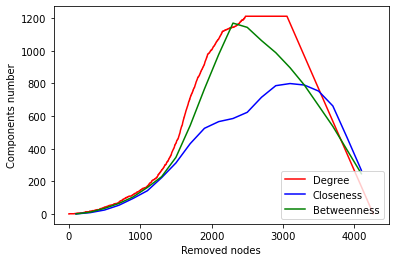

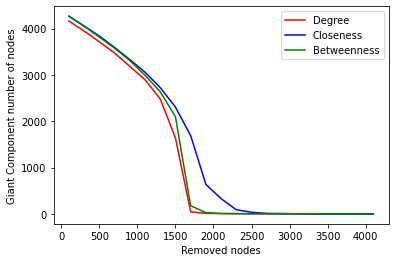

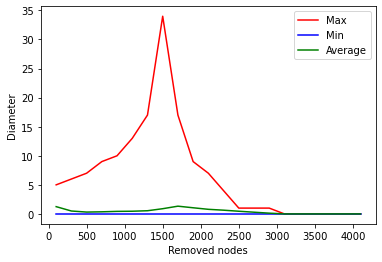

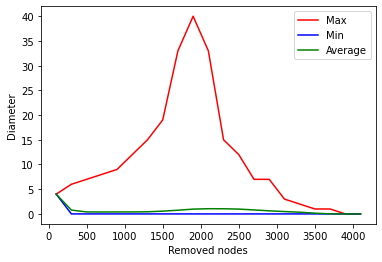

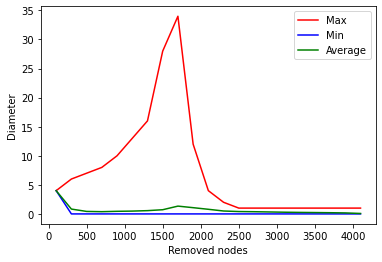

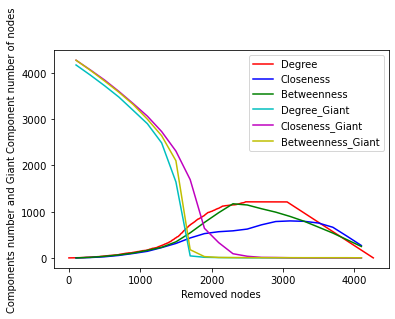

In [268]:
graph_robustness(C2,diametersOn = True)

::: Computing Degree :::

	Node with Max number of Edges:  covid  ||degree 0.622333000997009

	Node with Max number of Edges:  coronavirus  ||degree 0.5580374950139608

	Node with Max number of Edges:  say  ||degree 0.47895471773389187

	Node with Max number of Edges:  trump  ||degree 0.38966480446927376

	Node with Max number of Edges:  u  ||degree 0.370584713630014

	Node with Max number of Edges:  n  ||degree 0.36646706586826344

	Node with Max number of Edges:  pandemic  ||degree 0.3639448991814733

	Node with Max number of Edges:  president  ||degree 0.3524361022364217

	Node with Max number of Edges:  china  ||degree 0.3401238266427002

	Node with Max number of Edges:  new  ||degree 0.32141430283659606

	Node with Max number of Edges:  test  ||degree 0.27432567432567434

	Node with Max number of Edges:  people  ||degree 0.2541966426858513

	Node with Max number of Edges:  case  ||degree 0.22206675994403358

	Node with Max number of Edges:  one  ||degree 0.21571371451419433

	Node


	Node with Max number of Edges:  even  ||degree 0.08071107478545157

	Node with Max number of Edges:  give  ||degree 0.08052319640302473

	Node with Max number of Edges:  response  ||degree 0.080335241210139

	Node with Max number of Edges:  continue  ||degree 0.07994275199345736

	Node with Max number of Edges:  effort  ||degree 0.07934560327198364

	Node with Max number of Edges:  national  ||degree 0.07854366946205768

	Node with Max number of Edges:  announce  ||degree 0.0781505728314239

	Node with Max number of Edges:  minister  ||degree 0.07796193984039287

	Node with Max number of Edges:  record  ||degree 0.07777322963569382

	Node with Max number of Edges:  begin  ||degree 0.07717502558853634

	Node with Max number of Edges:  travel  ||degree 0.07616707616707617

	Node with Max number of Edges:  remain  ||degree 0.07577309031333196

	Node with Max number of Edges:  follow  ||degree 0.07455960671855796

	Node with Max number of Edges:  also  ||degree 0.0743700061462815

	Node 


	Node with Max number of Edges:  drug  ||degree 0.04737945492662474

	Node with Max number of Edges:  authority  ||degree 0.04717970224365695

	Node with Max number of Edges:  fall  ||degree 0.04718959731543624

	Node with Max number of Edges:  likely  ||degree 0.04698972099853157

	Node with Max number of Edges:  rally  ||degree 0.046579941250524545

	Node with Max number of Edges:  rate  ||degree 0.0465897166841553

	Node with Max number of Edges:  old  ||degree 0.04617968094038623

	Node with Max number of Edges:  four  ||degree 0.04597942473231156

	Node with Max number of Edges:  talk  ||degree 0.045569088618227636

	Node with Max number of Edges:  child  ||degree 0.04536862003780718

	Node with Max number of Edges:  bill  ||degree 0.04516806722689076

	Node with Max number of Edges:  among  ||degree 0.04496743013238075

	Node with Max number of Edges:  base  ||degree 0.044976881042454814

	Node with Max number of Edges:  industry  ||degree 0.04477611940298508

	Node with Max num


	Node with Max number of Edges:  write  ||degree 0.029285099052540915

	Node with Max number of Edges:  flu  ||degree 0.029076028429894468

	Node with Max number of Edges:  taiwan  ||degree 0.02908229211546747

	Node with Max number of Edges:  good  ||degree 0.028873087696617106

	Node with Max number of Edges:  local  ||degree 0.028879310344827585

	Node with Max number of Edges:  washington  ||degree 0.028885535675792197

	Node with Max number of Edges:  political  ||degree 0.028676153514445885

	Node with Max number of Edges:  seven  ||degree 0.028682337718352383

	Node with Max number of Edges:  ban  ||degree 0.028472821397756688

	Node with Max number of Edges:  delay  ||degree 0.0284789644012945

	Node with Max number of Edges:  physician  ||degree 0.028485110056107037

	Node with Max number of Edges:  bar  ||degree 0.028275415497517806

	Node with Max number of Edges:  director  ||degree 0.02828151986183074

	Node with Max number of Edges:  insight  ||degree 0.02828762686244871


	Node with Max number of Edges:  policy  ||degree 0.019902697921273773

	Node with Max number of Edges:  spike  ||degree 0.019907100199071003

	Node with Max number of Edges:  strong  ||degree 0.01991150442477876

	Node with Max number of Edges:  message  ||degree 0.019694622704138087

	Node with Max number of Edges:  moment  ||degree 0.019698981850376274

	Node with Max number of Edges:  six  ||degree 0.019703342926721275

	Node with Max number of Edges:  canada  ||degree 0.019486271036315325

	Node with Max number of Edges:  extend  ||degree 0.019490586932447398
----- Nodes removed:  500  -----

	Node with Max number of Edges:  impose  ||degree 0.01949490474080638

	Node with Max number of Edges:  police  ||degree 0.019499224462663417

	Node with Max number of Edges:  morning  ||degree 0.01928191489361702

	Node with Max number of Edges:  clear  ||degree 0.019064508978053646

	Node with Max number of Edges:  fast  ||degree 0.019068736141906874

	Node with Max number of Edges:  hand 


	Node with Max number of Edges:  speed  ||degree 0.014321436690156853

	Node with Max number of Edges:  trend  ||degree 0.01432469304229195

	Node with Max number of Edges:  away  ||degree 0.014100523083920855

	Node with Max number of Edges:  ballot  ||degree 0.014103730664240218

	Node with Max number of Edges:  brand  ||degree 0.014106939704209329

	Node with Max number of Edges:  course  ||degree 0.014110150204824761

	Node with Max number of Edges:  owner  ||degree 0.014113362167083999

	Node with Max number of Edges:  serious  ||degree 0.014116575591985429

	Node with Max number of Edges:  visit  ||degree 0.014119790480528353

	Node with Max number of Edges:  defend  ||degree 0.013895216400911162

	Node with Max number of Edges:  enter  ||degree 0.01389838231943495

	Node with Max number of Edges:  star  ||degree 0.01390154968094804

	Node with Max number of Edges:  suffer  ||degree 0.013904718486437201

	Node with Max number of Edges:  ten  ||degree 0.013907888736890105

	Node 


	Node with Max number of Edges:  cannot  ||degree 0.010762751520823585

	Node with Max number of Edges:  emerge  ||degree 0.010765270301895623

	Node with Max number of Edges:  flag  ||degree 0.010767790262172285

	Node with Max number of Edges:  football  ||degree 0.010770311402481855

	Node with Max number of Edges:  singapore  ||degree 0.010772833723653397

	Node with Max number of Edges:  teacher  ||degree 0.010775357226516749

	Node with Max number of Edges:  trip  ||degree 0.01077788191190253

	Node with Max number of Edges:  commission  ||degree 0.010546051089758613

	Node with Max number of Edges:  lot  ||degree 0.010548523206751056

	Node with Max number of Edges:  music  ||degree 0.010550996483001172

	Node with Max number of Edges:  product  ||degree 0.010553470919324577

	Node with Max number of Edges:  series  ||degree 0.01055594651653765

	Node with Max number of Edges:  spending  ||degree 0.01055842327545753

	Node with Max number of Edges:  wait  ||degree 0.01056090119


	Node with Max number of Edges:  plane  ||degree 0.008433734939759036

	Node with Max number of Edges:  process  ||degree 0.008435767654856593

	Node with Max number of Edges:  propose  ||degree 0.008437801350048216

	Node with Max number of Edges:  sharply  ||degree 0.008439836026042922

	Node with Max number of Edges:  uncertainty  ||degree 0.00844187168355041

	Node with Max number of Edges:  warning  ||degree 0.008443908323281062

	Node with Max number of Edges:  continent  ||degree 0.008204633204633206

	Node with Max number of Edges:  county  ||degree 0.008206613565049481

	Node with Max number of Edges:  exchange  ||degree 0.00820859488169966

	Node with Max number of Edges:  fan  ||degree 0.008210577155276504

	Node with Max number of Edges:  investigation  ||degree 0.00821256038647343

	Node with Max number of Edges:  let  ||degree 0.008214544575984537

	Node with Max number of Edges:  marine  ||degree 0.008216529724504592

	Node with Max number of Edges:  plant  ||degree 0.0


	Node with Max number of Edges:  theme  ||degree 0.006941001487357461

	Node with Max number of Edges:  address  ||degree 0.006694768162658071

	Node with Max number of Edges:  bet  ||degree 0.006696428571428571

	Node with Max number of Edges:  blame  ||degree 0.006698089804018854

	Node with Max number of Edges:  cure  ||degree 0.006699751861042184

	Node with Max number of Edges:  institute  ||degree 0.0067014147431124355

	Node with Max number of Edges:  labour  ||degree 0.0067030784508440916

	Node with Max number of Edges:  league  ||degree 0.006704742984852248

	Node with Max number of Edges:  negotiation  ||degree 0.006706408345752608

	Node with Max number of Edges:  neighbor  ||degree 0.006708074534161491

	Node with Max number of Edges:  slam  ||degree 0.006709741550695824

	Node with Max number of Edges:  strike  ||degree 0.006711409395973154

	Node with Max number of Edges:  technology  ||degree 0.006713078070611635

	Node with Max number of Edges:  topic  ||degree 0.0067


	Node with Max number of Edges:  focus  ||degree 0.005365355135411344

	Node with Max number of Edges:  furlough  ||degree 0.005366726296958855

	Node with Max number of Edges:  interview  ||degree 0.005368098159509203

	Node with Max number of Edges:  jinping  ||degree 0.005369470723600103

	Node with Max number of Edges:  listing  ||degree 0.00537084398976982

	Node with Max number of Edges:  living  ||degree 0.005372217958557176

	Node with Max number of Edges:  mountain  ||degree 0.0053735926305015355

	Node with Max number of Edges:  prayer  ||degree 0.0053749680061428206

	Node with Max number of Edges:  racial  ||degree 0.005376344086021506

	Node with Max number of Edges:  responsibility  ||degree 0.005377720870678617

	Node with Max number of Edges:  swiss  ||degree 0.005379098360655738

	Node with Max number of Edges:  transmit  ||degree 0.005380476556495004

	Node with Max number of Edges:  brother  ||degree 0.005125576627370579

	Node with Max number of Edges:  climb  ||de


	Node with Max number of Edges:  meadow  ||degree 0.004474861805738352

	Node with Max number of Edges:  motorcade  ||degree 0.004476040021063717

	Node with Max number of Edges:  probe  ||degree 0.004477218856992362

	Node with Max number of Edges:  protester  ||degree 0.004478398314014752

	Node with Max number of Edges:  pub  ||degree 0.0044795783926218705

	Node with Max number of Edges:  quick  ||degree 0.004480759093305219

	Node with Max number of Edges:  rescue  ||degree 0.004481940416556815

	Node with Max number of Edges:  room  ||degree 0.004483122362869198

	Node with Max number of Edges:  spokesman  ||degree 0.004484304932735427

	Node with Max number of Edges:  swift  ||degree 0.004485488126649076

	Node with Max number of Edges:  tally  ||degree 0.0044866719451042494

	Node with Max number of Edges:  tibet  ||degree 0.004487856388595565

	Node with Max number of Edges:  tout  ||degree 0.004489041457618167

	Node with Max number of Edges:  undermine  ||degree 0.004490227


	Node with Max number of Edges:  opera  ||degree 0.0038022813688212923

	Node with Max number of Edges:  pentagon  ||degree 0.003803314316761749

	Node with Max number of Edges:  phase  ||degree 0.0038043478260869567

	Node with Max number of Edges:  profound  ||degree 0.0038053818972546886

	Node with Max number of Edges:  protection  ||degree 0.003806416530723219

	Node with Max number of Edges:  ramp  ||degree 0.003807451726951319

	Node with Max number of Edges:  retailer  ||degree 0.003808487486398259

	Node with Max number of Edges:  roughly  ||degree 0.0038095238095238095

	Node with Max number of Edges:  sense  ||degree 0.003810560696788242

	Node with Max number of Edges:  solution  ||degree 0.0038115981486523277

	Node with Max number of Edges:  square  ||degree 0.0038126361655773425

	Node with Max number of Edges:  temperature  ||degree 0.0038136747480250616

	Node with Max number of Edges:  title  ||degree 0.0038147138964577656

	Node with Max number of Edges:  tourism  |


	Node with Max number of Edges:  father  ||degree 0.003089019938219601

	Node with Max number of Edges:  finally  ||degree 0.0030898876404494386

	Node with Max number of Edges:  fishing  ||degree 0.0030907558302894073

	Node with Max number of Edges:  handful  ||degree 0.0030916245081506464

	Node with Max number of Edges:  hire  ||degree 0.003092493674444757

	Node with Max number of Edges:  identify  ||degree 0.003093363329583802

	Node with Max number of Edges:  immediate  ||degree 0.0030942334739803095

	Node with Max number of Edges:  incorrect  ||degree 0.0030951041080472708

	Node with Max number of Edges:  individual  ||degree 0.003095975232198142

	Node with Max number of Edges:  intensive  ||degree 0.003096846846846847

	Node with Max number of Edges:  invention  ||degree 0.003097718952407772

	Node with Max number of Edges:  king  ||degree 0.003098591549295775

	Node with Max number of Edges:  lab  ||degree 0.003099464637926176

	Node with Max number of Edges:  merger  ||d


	Node with Max number of Edges:  demonstrator  ||degree 0.0026155187445510027

	Node with Max number of Edges:  diplomat  ||degree 0.002616279069767442

	Node with Max number of Edges:  disappointing  ||degree 0.0026170398371619654

	Node with Max number of Edges:  divide  ||degree 0.0026178010471204186

	Node with Max number of Edges:  e  ||degree 0.002618562700029095

	Node with Max number of Edges:  education  ||degree 0.002619324796274738

	Node with Max number of Edges:  equity  ||degree 0.002620087336244542

	Node with Max number of Edges:  feed  ||degree 0.0026208503203261502

	Node with Max number of Edges:  fly  ||degree 0.0026216137489076608

	Node with Max number of Edges:  generation  ||degree 0.0026223776223776225

	Node with Max number of Edges:  haul  ||degree 0.0026231419411250367

	Node with Max number of Edges:  holy  ||degree 0.0026239067055393583

	Node with Max number of Edges:  hungry  ||degree 0.002624671916010499

	Node with Max number of Edges:  ice  ||degree 


	Node with Max number of Edges:  surveillance  ||degree 0.0024031240612796636

	Node with Max number of Edges:  tracing  ||degree 0.002403846153846154

	Node with Max number of Edges:  unexpected  ||degree 0.0024045686804929365

	Node with Max number of Edges:  unveil  ||degree 0.0024052916416115455

	Node with Max number of Edges:  upbeat  ||degree 0.002406015037593985

	Node with Max number of Edges:  usually  ||degree 0.0024067388688327317

	Node with Max number of Edges:  ventilation  ||degree 0.0024074631357207344

	Node with Max number of Edges:  via  ||degree 0.002408187838651415

	Node with Max number of Edges:  vivid  ||degree 0.002408912978018669

	Node with Max number of Edges:  wood  ||degree 0.0024096385542168677

	Node with Max number of Edges:  zone  ||degree 0.0024103645676408557

	Node with Max number of Edges:  admiral  ||degree 0.002109704641350211

	Node with Max number of Edges:  afraid  ||degree 0.0021103406692794696

	Node with Max number of Edges:  allegation  


	Node with Max number of Edges:  army  ||degree 0.0018679950186799503

	Node with Max number of Edges:  asset  ||degree 0.0018685767673621927

	Node with Max number of Edges:  avert  ||degree 0.001869158878504673

	Node with Max number of Edges:  ballet  ||degree 0.0018697413524462448

	Node with Max number of Edges:  banker  ||degree 0.0018703241895261845

	Node with Max number of Edges:  bankruptcy  ||degree 0.0018709073900841909

	Node with Max number of Edges:  belt  ||degree 0.0018714909544603868

	Node with Max number of Edges:  bind  ||degree 0.0018720748829953197

	Node with Max number of Edges:  book  ||degree 0.0018726591760299626

	Node with Max number of Edges:  brief  ||degree 0.0018732438339057135

	Node with Max number of Edges:  brink  ||degree 0.0018738288569643971

	Node with Max number of Edges:  busy  ||degree 0.0018744142455482662

	Node with Max number of Edges:  button  ||degree 0.001875

	Node with Max number of Edges:  campus  ||degree 0.001875586120662707

	N


	Node with Max number of Edges:  collect  ||degree 0.0016155088852988692

	Node with Max number of Edges:  commitment  ||degree 0.0016160310277957336

	Node with Max number of Edges:  communication  ||degree 0.0016165535079211122

	Node with Max number of Edges:  communist  ||degree 0.0016170763260025874

	Node with Max number of Edges:  compensation  ||degree 0.0016175994823681658

	Node with Max number of Edges:  comply  ||degree 0.0016181229773462784

	Node with Max number of Edges:  conductor  ||degree 0.0016186468112657818

	Node with Max number of Edges:  cone  ||degree 0.0016191709844559587

	Node with Max number of Edges:  conflicting  ||degree 0.0016196954972465176

	Node with Max number of Edges:  confusion  ||degree 0.0016202203499675956

	Node with Max number of Edges:  corp  ||degree 0.0016207455429497568

	Node with Max number of Edges:  correspondent  ||degree 0.0016212710765239947

	Node with Max number of Edges:  current  ||degree 0.001621796951021732

	Node with Max 


	Node with Max number of Edges:  attention  ||degree 0.0013440860215053765

	Node with Max number of Edges:  attribute  ||degree 0.0013445378151260505

	Node with Max number of Edges:  bake  ||degree 0.0013449899125756557

	Node with Max number of Edges:  basement  ||degree 0.0013454423141607804

	Node with Max number of Edges:  bizarre  ||degree 0.0013458950201884253

	Node with Max number of Edges:  boat  ||degree 0.0013463480309660047

	Node with Max number of Edges:  bolster  ||degree 0.0013468013468013469

	Node with Max number of Edges:  borrowing  ||degree 0.0013472549680026945

	Node with Max number of Edges:  broaden  ||degree 0.0013477088948787063

	Node with Max number of Edges:  card  ||degree 0.0013481631277384564

	Node with Max number of Edges:  careful  ||degree 0.0013486176668914363

	Node with Max number of Edges:  carrier  ||degree 0.0013490725126475548

	Node with Max number of Edges:  cautionary  ||degree 0.001349527665317139

	Node with Max number of Edges:  clar


	Node with Max number of Edges:  remember  ||degree 0.0013990905911157748

	Node with Max number of Edges:  requirement  ||degree 0.0013995801259622112

	Node with Max number of Edges:  respiratory  ||degree 0.001400070003500175

	Node with Max number of Edges:  retired  ||degree 0.0014005602240896359

	Node with Max number of Edges:  rickshaw  ||degree 0.0014010507880910684

	Node with Max number of Edges:  risky  ||degree 0.001401541695865452

	Node with Max number of Edges:  rite  ||degree 0.0014020329477742728

	Node with Max number of Edges:  roundup  ||degree 0.001402524544179523

	Node with Max number of Edges:  saint  ||degree 0.0014030164854437039

	Node with Max number of Edges:  sample  ||degree 0.0014035087719298245

	Node with Max number of Edges:  sceptic  ||degree 0.001404001404001404

	Node with Max number of Edges:  seemingly  ||degree 0.0014044943820224719

	Node with Max number of Edges:  semester  ||degree 0.0014049877063575693

	Node with Max number of Edges:  sev


	Node with Max number of Edges:  distribution  ||degree 0.0010921004732435385

	Node with Max number of Edges:  donna  ||degree 0.0010924981791697016

	Node with Max number of Edges:  dos  ||degree 0.001092896174863388

	Node with Max number of Edges:  draft  ||degree 0.0010932944606413995

	Node with Max number of Edges:  dynasty  ||degree 0.001093693036820999

	Node with Max number of Edges:  eclipse  ||degree 0.0010940919037199124

	Node with Max number of Edges:  edition  ||degree 0.0010944910616563297

	Node with Max number of Edges:  el  ||degree 0.001094890510948905

	Node with Max number of Edges:  elation  ||degree 0.001095290251916758

	Node with Max number of Edges:  encapsulate  ||degree 0.001095690284879474

	Node with Max number of Edges:  endorse  ||degree 0.0010960906101571063

	Node with Max number of Edges:  engagement  ||degree 0.0010964912280701754

	Node with Max number of Edges:  enrollment  ||degree 0.0010968921389396709

	Node with Max number of Edges:  espiona


	Node with Max number of Edges:  sole  ||degree 0.001139384732244588

	Node with Max number of Edges:  soleil  ||degree 0.0011398176291793312

	Node with Max number of Edges:  southwest  ||degree 0.0011402508551881414

	Node with Max number of Edges:  speaking  ||degree 0.0011406844106463879

	Node with Max number of Edges:  stagger  ||degree 0.0011411182959300114

	Node with Max number of Edges:  stamp  ||degree 0.001141552511415525

	Node with Max number of Edges:  standpoint  ||degree 0.0011419870574800152

	Node with Max number of Edges:  statistic  ||degree 0.0011424219345011425

	Node with Max number of Edges:  sticky  ||degree 0.001142857142857143

	Node with Max number of Edges:  strap  ||degree 0.0011432926829268294

	Node with Max number of Edges:  stream  ||degree 0.001143728555089592

	Node with Max number of Edges:  string  ||degree 0.0011441647597254005

	Node with Max number of Edges:  success  ||degree 0.0011446012972148036

	Node with Max number of Edges:  suppose  ||


	Node with Max number of Edges:  champion  ||degree 0.0007942811755361397

	Node with Max number of Edges:  changer  ||degree 0.0007945967421533572

	Node with Max number of Edges:  character  ||degree 0.000794912559618442

	Node with Max number of Edges:  charitable  ||degree 0.0007952286282306163
----- Nodes removed:  2500  -----

	Node with Max number of Edges:  choice  ||degree 0.0007955449482895784

	Node with Max number of Edges:  choke  ||degree 0.0007958615200955034

	Node with Max number of Edges:  church  ||degree 0.0007961783439490446

	Node with Max number of Edges:  clash  ||degree 0.0007964954201513341

	Node with Max number of Edges:  cleaning  ||degree 0.0007968127490039841

	Node with Max number of Edges:  clima  ||degree 0.0007971303308090873

	Node with Max number of Edges:  cloud  ||degree 0.0007974481658692185

	Node with Max number of Edges:  clutch  ||degree 0.0007977662544874351

	Node with Max number of Edges:  clutter  ||degree 0.0007980845969672786

	Node wi


	Node with Max number of Edges:  hotter  ||degree 0.0008329862557267805

	Node with Max number of Edges:  humanity  ||degree 0.0008333333333333334

	Node with Max number of Edges:  immoral  ||degree 0.0008336807002917883

	Node with Max number of Edges:  incident  ||degree 0.0008340283569641367

	Node with Max number of Edges:  inclusive  ||degree 0.0008343763037129745

	Node with Max number of Edges:  indict  ||degree 0.0008347245409015025

	Node with Max number of Edges:  indignity  ||degree 0.0008350730688935282

	Node with Max number of Edges:  induce  ||degree 0.000835421888053467

	Node with Max number of Edges:  infant  ||degree 0.0008357709987463436

	Node with Max number of Edges:  inflammation  ||degree 0.0008361204013377926

	Node with Max number of Edges:  inflected  ||degree 0.000836470096194061

	Node with Max number of Edges:  informal  ||degree 0.0008368200836820083

	Node with Max number of Edges:  inherent  ||degree 0.0008371703641691084

	Node with Max number of Edg


	Node with Max number of Edges:  sex  ||degree 0.0008729812309035355

	Node with Max number of Edges:  shed  ||degree 0.0008733624454148472

	Node with Max number of Edges:  shrink  ||degree 0.0008737439930100481

	Node with Max number of Edges:  shy  ||degree 0.0008741258741258741

	Node with Max number of Edges:  skilled  ||degree 0.0008745080891998251

	Node with Max number of Edges:  sledge  ||degree 0.0008748906386701663

	Node with Max number of Edges:  slowdown  ||degree 0.00087527352297593

	Node with Max number of Edges:  society  ||degree 0.0008756567425569177

	Node with Max number of Edges:  spotlight  ||degree 0.0008760402978537013

	Node with Max number of Edges:  sri  ||degree 0.0008764241893076249

	Node with Max number of Edges:  stadium  ||degree 0.0008768084173608067

	Node with Max number of Edges:  staffer  ||degree 0.0008771929824561404

	Node with Max number of Edges:  starred  ||degree 0.0008775778850372971

	Node with Max number of Edges:  status  ||degree 0.0


	Node with Max number of Edges:  battery  ||degree 0.00045871559633027525

	Node with Max number of Edges:  beetle  ||degree 0.0004589261128958238

	Node with Max number of Edges:  beginning  ||degree 0.0004591368227731864

	Node with Max number of Edges:  behemoth  ||degree 0.00045934772622875517

	Node with Max number of Edges:  bidding  ||degree 0.00045955882352941176

	Node with Max number of Edges:  bike  ||degree 0.0004597701149425287

	Node with Max number of Edges:  bin  ||degree 0.00045998160073597056

	Node with Max number of Edges:  biology  ||degree 0.0004601932811780948

	Node with Max number of Edges:  birth  ||degree 0.00046040515653775324

	Node with Max number of Edges:  blanco  ||degree 0.00046061722708429296

	Node with Max number of Edges:  bleak  ||degree 0.0004608294930875576

	Node with Max number of Edges:  blockade  ||degree 0.0004610419548178884

	Node with Max number of Edges:  blowout  ||degree 0.00046125461254612545

	Node with Max number of Edges:  bomber


	Node with Max number of Edges:  cricket  ||degree 0.00048426150121065375

	Node with Max number of Edges:  crimp  ||degree 0.00048449612403100775

	Node with Max number of Edges:  crowded  ||degree 0.0004847309743092584

	Node with Max number of Edges:  cull  ||degree 0.00048496605237633366

	Node with Max number of Edges:  cultural  ||degree 0.00048520135856380397

	Node with Max number of Edges:  darkly  ||degree 0.0004854368932038835

	Node with Max number of Edges:  dashboard  ||degree 0.00048567265662943174

	Node with Max number of Edges:  davy  ||degree 0.00048590864917395527

	Node with Max number of Edges:  decease  ||degree 0.0004861448711716091

	Node with Max number of Edges:  deepen  ||degree 0.00048638132295719845

	Node with Max number of Edges:  defeat  ||degree 0.00048661800486618007

	Node with Max number of Edges:  defensive  ||degree 0.0004868549172346641

	Node with Max number of Edges:  defraud  ||degree 0.0004870920603994155

	Node with Max number of Edges:  de


	Node with Max number of Edges:  favor  ||degree 0.0005125576627370579

	Node with Max number of Edges:  fed  ||degree 0.0005128205128205128

	Node with Max number of Edges:  feral  ||degree 0.000513083632632119

	Node with Max number of Edges:  fetch  ||degree 0.000513347022587269

	Node with Max number of Edges:  fiction  ||degree 0.0005136106831022085

	Node with Max number of Edges:  finale  ||degree 0.0005138746145940391

	Node with Max number of Edges:  firmly  ||degree 0.0005141388174807198

	Node with Max number of Edges:  fit  ||degree 0.00051440329218107

	Node with Max number of Edges:  flagging  ||degree 0.000514668039114771

	Node with Max number of Edges:  flamboyant  ||degree 0.0005149330587023687

	Node with Max number of Edges:  flamenco  ||degree 0.0005151983513652757

	Node with Max number of Edges:  flare  ||degree 0.0005154639175257732

	Node with Max number of Edges:  flat  ||degree 0.0005157297576070139

	Node with Max number of Edges:  flood  ||degree 0.0005159


	Node with Max number of Edges:  kelly  ||degree 0.0005443658138268917

	Node with Max number of Edges:  kent  ||degree 0.0005446623093681918

	Node with Max number of Edges:  kiosk  ||degree 0.0005449591280653951

	Node with Max number of Edges:  kiwi  ||degree 0.0005452562704471102

	Node with Max number of Edges:  knowledge  ||degree 0.0005455537370430987

	Node with Max number of Edges:  lake  ||degree 0.0005458515283842794

	Node with Max number of Edges:  lament  ||degree 0.0005461496450027307

	Node with Max number of Edges:  lari  ||degree 0.000546448087431694

	Node with Max number of Edges:  layer  ||degree 0.0005467468562055768

	Node with Max number of Edges:  leap  ||degree 0.0005470459518599562

	Node with Max number of Edges:  leftover  ||degree 0.0005473453749315818

	Node with Max number of Edges:  length  ||degree 0.000547645125958379

	Node with Max number of Edges:  lengthy  ||degree 0.000547945205479452

	Node with Max number of Edges:  lens  ||degree 0.0005482456


	Node with Max number of Edges:  positivity  ||degree 0.0005807200929152149

	Node with Max number of Edges:  preclude  ||degree 0.0005810575246949448

	Node with Max number of Edges:  pregnant  ||degree 0.0005813953488372093

	Node with Max number of Edges:  premium  ||degree 0.0005817335660267597

	Node with Max number of Edges:  preparation  ||degree 0.0005820721769499418

	Node with Max number of Edges:  preservation  ||degree 0.0005824111822947001

	Node with Max number of Edges:  pressing  ||degree 0.0005827505827505828

	Node with Max number of Edges:  prey  ||degree 0.0005830903790087463
----- Nodes removed:  3300  -----

	Node with Max number of Edges:  prince  ||degree 0.0005834305717619603

	Node with Max number of Edges:  problematic  ||degree 0.0005837711617046118

	Node with Max number of Edges:  producer  ||degree 0.0005841121495327102

	Node with Max number of Edges:  progressive  ||degree 0.0005844535359438924

	Node with Max number of Edges:  projection  ||degree 0.0


	Node with Max number of Edges:  absorb  ||degree 0.0

	Node with Max number of Edges:  abundance  ||degree 0.0

	Node with Max number of Edges:  abuzz  ||degree 0.0

	Node with Max number of Edges:  accessibility  ||degree 0.0

	Node with Max number of Edges:  accordingly  ||degree 0.0

	Node with Max number of Edges:  accurate  ||degree 0.0

	Node with Max number of Edges:  acquire  ||degree 0.0

	Node with Max number of Edges:  acre  ||degree 0.0

	Node with Max number of Edges:  added  ||degree 0.0

	Node with Max number of Edges:  addiction  ||degree 0.0

	Node with Max number of Edges:  admission  ||degree 0.0

	Node with Max number of Edges:  admit  ||degree 0.0

	Node with Max number of Edges:  adversary  ||degree 0.0

	Node with Max number of Edges:  adverse  ||degree 0.0

	Node with Max number of Edges:  affected  ||degree 0.0

	Node with Max number of Edges:  aggression  ||degree 0.0

	Node with Max number of Edges:  agonize  ||degree 0.0

	Node with Max number of Edges:  a


	Node with Max number of Edges:  comprise  ||degree 0.0

	Node with Max number of Edges:  compulsory  ||degree 0.0

	Node with Max number of Edges:  con  ||degree 0.0

	Node with Max number of Edges:  conceal  ||degree 0.0

	Node with Max number of Edges:  concentration  ||degree 0.0

	Node with Max number of Edges:  conclude  ||degree 0.0

	Node with Max number of Edges:  condensed  ||degree 0.0

	Node with Max number of Edges:  conditional  ||degree 0.0

	Node with Max number of Edges:  confidential  ||degree 0.0

	Node with Max number of Edges:  confuse  ||degree 0.0

	Node with Max number of Edges:  connaught  ||degree 0.0

	Node with Max number of Edges:  conscious  ||degree 0.0

	Node with Max number of Edges:  considerably  ||degree 0.0

	Node with Max number of Edges:  consideration  ||degree 0.0

	Node with Max number of Edges:  consistent  ||degree 0.0

	Node with Max number of Edges:  constant  ||degree 0.0

	Node with Max number of Edges:  construction  ||degree 0.0

	Node


	Node with Max number of Edges:  empire  ||degree 0.0

	Node with Max number of Edges:  employment  ||degree 0.0

	Node with Max number of Edges:  enemy  ||degree 0.0

	Node with Max number of Edges:  energetic  ||degree 0.0

	Node with Max number of Edges:  enforcement  ||degree 0.0

	Node with Max number of Edges:  engage  ||degree 0.0

	Node with Max number of Edges:  ensemble  ||degree 0.0

	Node with Max number of Edges:  enthusiasm  ||degree 0.0

	Node with Max number of Edges:  entrapment  ||degree 0.0

	Node with Max number of Edges:  entrepreneur  ||degree 0.0

	Node with Max number of Edges:  environment  ||degree 0.0

	Node with Max number of Edges:  envoy  ||degree 0.0

	Node with Max number of Edges:  epicenter  ||degree 0.0

	Node with Max number of Edges:  epidemiologist  ||degree 0.0

	Node with Max number of Edges:  equitable  ||degree 0.0

	Node with Max number of Edges:  equitably  ||degree 0.0

	Node with Max number of Edges:  erase  ||degree 0.0

	Node with Max nu


	Node with Max number of Edges:  hamper  ||degree 0.0

	Node with Max number of Edges:  handy  ||degree 0.0

	Node with Max number of Edges:  harsh  ||degree 0.0

	Node with Max number of Edges:  hasten  ||degree 0.0

	Node with Max number of Edges:  hat  ||degree 0.0

	Node with Max number of Edges:  heartache  ||degree 0.0

	Node with Max number of Edges:  heartland  ||degree 0.0

	Node with Max number of Edges:  heat  ||degree 0.0

	Node with Max number of Edges:  heating  ||degree 0.0

	Node with Max number of Edges:  heavy  ||degree 0.0

	Node with Max number of Edges:  hectare  ||degree 0.0

	Node with Max number of Edges:  heed  ||degree 0.0

	Node with Max number of Edges:  height  ||degree 0.0

	Node with Max number of Edges:  helpful  ||degree 0.0

	Node with Max number of Edges:  herbal  ||degree 0.0

	Node with Max number of Edges:  hesitate  ||degree 0.0

	Node with Max number of Edges:  hiatus  ||degree 0.0

	Node with Max number of Edges:  highway  ||degree 0.0

	Node w


	Node with Max number of Edges:  lightning  ||degree 0.0

	Node with Max number of Edges:  linked  ||degree 0.0

	Node with Max number of Edges:  listed  ||degree 0.0

	Node with Max number of Edges:  listener  ||degree 0.0

	Node with Max number of Edges:  lit  ||degree 0.0

	Node with Max number of Edges:  literally  ||degree 0.0

	Node with Max number of Edges:  litigator  ||degree 0.0

	Node with Max number of Edges:  livestock  ||degree 0.0

	Node with Max number of Edges:  looming  ||degree 0.0

	Node with Max number of Edges:  lucrative  ||degree 0.0

	Node with Max number of Edges:  luna  ||degree 0.0

	Node with Max number of Edges:  lure  ||degree 0.0

	Node with Max number of Edges:  mad  ||degree 0.0

	Node with Max number of Edges:  magnificent  ||degree 0.0

	Node with Max number of Edges:  malign  ||degree 0.0

	Node with Max number of Edges:  malnutrition  ||degree 0.0

	Node with Max number of Edges:  mane  ||degree 0.0

	Node with Max number of Edges:  manifestation 


	Node with Max number of Edges:  outline  ||degree 0.0

	Node with Max number of Edges:  output  ||degree 0.0

	Node with Max number of Edges:  outrage  ||degree 0.0

	Node with Max number of Edges:  outright  ||degree 0.0

	Node with Max number of Edges:  outstrip  ||degree 0.0

	Node with Max number of Edges:  outweigh  ||degree 0.0

	Node with Max number of Edges:  oval  ||degree 0.0

	Node with Max number of Edges:  overcome  ||degree 0.0

	Node with Max number of Edges:  overlap  ||degree 0.0

	Node with Max number of Edges:  overload  ||degree 0.0

	Node with Max number of Edges:  overweight  ||degree 0.0

	Node with Max number of Edges:  overwhelming  ||degree 0.0

	Node with Max number of Edges:  owe  ||degree 0.0

	Node with Max number of Edges:  pac  ||degree 0.0

	Node with Max number of Edges:  pact  ||degree 0.0

	Node with Max number of Edges:  page  ||degree 0.0

	Node with Max number of Edges:  pain  ||degree 0.0

	Node with Max number of Edges:  palm  ||degree 0.0

	N


	Node with Max number of Edges:  raft  ||degree 0.0

	Node with Max number of Edges:  rag  ||degree 0.0

	Node with Max number of Edges:  rage  ||degree 0.0

	Node with Max number of Edges:  railroad  ||degree 0.0

	Node with Max number of Edges:  rake  ||degree 0.0

	Node with Max number of Edges:  randomize  ||degree 0.0

	Node with Max number of Edges:  ranked  ||degree 0.0

	Node with Max number of Edges:  rarely  ||degree 0.0

	Node with Max number of Edges:  rash  ||degree 0.0

	Node with Max number of Edges:  ratio  ||degree 0.0

	Node with Max number of Edges:  raucous  ||degree 0.0

	Node with Max number of Edges:  rea  ||degree 0.0

	Node with Max number of Edges:  reading  ||degree 0.0

	Node with Max number of Edges:  reaffirm  ||degree 0.0

	Node with Max number of Edges:  reallocate  ||degree 0.0

	Node with Max number of Edges:  rear  ||degree 0.0

	Node with Max number of Edges:  reasonable  ||degree 0.0

	Node with Max number of Edges:  rebirth  ||degree 0.0

	Node wi


	Node with Max number of Edges:  scuffle  ||degree 0.0

	Node with Max number of Edges:  sculpture  ||degree 0.0

	Node with Max number of Edges:  scuttle  ||degree 0.0

	Node with Max number of Edges:  seat  ||degree 0.0

	Node with Max number of Edges:  seated  ||degree 0.0

	Node with Max number of Edges:  seaweed  ||degree 0.0

	Node with Max number of Edges:  seeker  ||degree 0.0

	Node with Max number of Edges:  selection  ||degree 0.0

	Node with Max number of Edges:  selfless  ||degree 0.0

	Node with Max number of Edges:  semiconductor  ||degree 0.0

	Node with Max number of Edges:  sensation  ||degree 0.0

	Node with Max number of Edges:  sensitive  ||degree 0.0

	Node with Max number of Edges:  sent  ||degree 0.0

	Node with Max number of Edges:  serenade  ||degree 0.0

	Node with Max number of Edges:  seriousness  ||degree 0.0

	Node with Max number of Edges:  serum  ||degree 0.0

	Node with Max number of Edges:  sesame  ||degree 0.0

	Node with Max number of Edges:  setba


	Node with Max number of Edges:  stunning  ||degree 0.0

	Node with Max number of Edges:  stunningly  ||degree 0.0

	Node with Max number of Edges:  stunt  ||degree 0.0

	Node with Max number of Edges:  stupid  ||degree 0.0

	Node with Max number of Edges:  sturgeon  ||degree 0.0

	Node with Max number of Edges:  stymie  ||degree 0.0

	Node with Max number of Edges:  sub  ||degree 0.0

	Node with Max number of Edges:  subdivision  ||degree 0.0

	Node with Max number of Edges:  subdue  ||degree 0.0

	Node with Max number of Edges:  sublet  ||degree 0.0

	Node with Max number of Edges:  submission  ||degree 0.0

	Node with Max number of Edges:  subscribe  ||degree 0.0

	Node with Max number of Edges:  subsequent  ||degree 0.0

	Node with Max number of Edges:  subsequently  ||degree 0.0

	Node with Max number of Edges:  subsidiary  ||degree 0.0

	Node with Max number of Edges:  substance  ||degree 0.0

	Node with Max number of Edges:  subtext  ||degree 0.0

	Node with Max number of Edges

	Node with Max number of Edges:  undeclared  ||degree 0.0

	Node with Max number of Edges:  underestimate  ||degree 0.0

	Node with Max number of Edges:  undergo  ||degree 0.0

	Node with Max number of Edges:  undergoing  ||degree 0.0

	Node with Max number of Edges:  undergrad  ||degree 0.0

	Node with Max number of Edges:  undergraduate  ||degree 0.0

	Node with Max number of Edges:  underlie  ||degree 0.0

	Node with Max number of Edges:  underplay  ||degree 0.0

	Node with Max number of Edges:  underprivileged  ||degree 0.0

	Node with Max number of Edges:  undersea  ||degree 0.0

	Node with Max number of Edges:  understanding  ||degree 0.0

	Node with Max number of Edges:  understood  ||degree 0.0

	Node with Max number of Edges:  underwater  ||degree 0.0

	Node with Max number of Edges:  underway  ||degree 0.0

	Node with Max number of Edges:  underwear  ||degree 0.0

	Node with Max number of Edges:  undeterred  ||degree 0.0

	Node with Max number of Edges:  undone  ||degree 0.0


::: Computing Closeness :::
----- Nodes removed:  0  -----

	Node with Max number of Edges:  covid  ||closeness 0.7256547532918536
----- Nodes removed:  1  -----

	Node with Max number of Edges:  wave  ||closeness 0.47326999339855447
----- Nodes removed:  2  -----

	Node with Max number of Edges:  launch  ||closeness 0.4086526865930265
----- Nodes removed:  3  -----

	Node with Max number of Edges:  criticize  ||closeness 0.3572654234083576
----- Nodes removed:  4  -----

	Node with Max number of Edges:  common  ||closeness 0.3108122067039711
----- Nodes removed:  5  -----

	Node with Max number of Edges:  focus  ||closeness 0.2623201154340637
----- Nodes removed:  6  -----

	Node with Max number of Edges:  rapidly  ||closeness 0.2139579004571173
----- Nodes removed:  7  -----

	Node with Max number of Edges:  opera  ||closeness 0.1615604835508309
----- Nodes removed:  8  -----

	Node with Max number of Edges:  dame  ||closeness 0.11734601415760161
----- Nodes removed:  9  -----

	Node

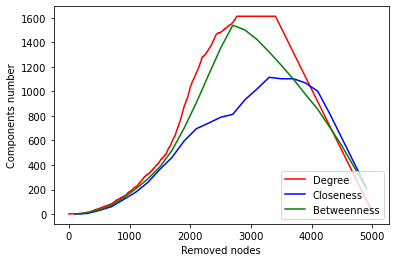

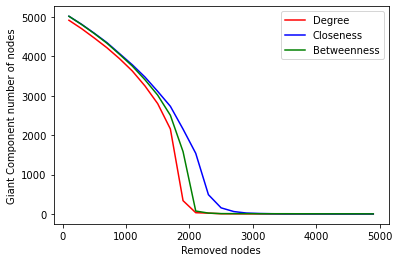

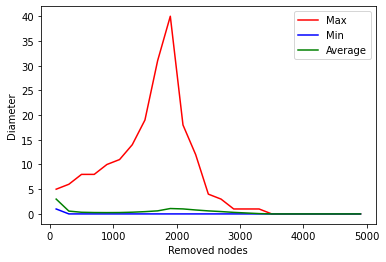

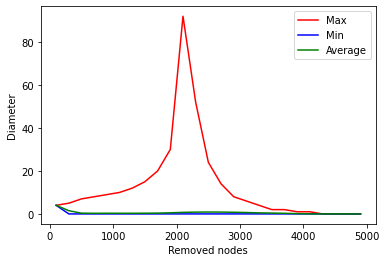

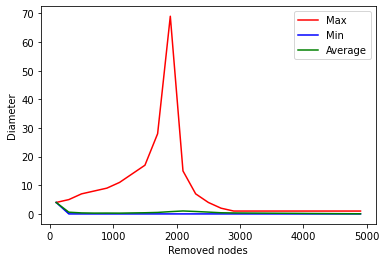

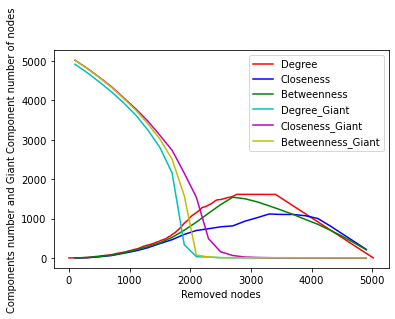

In [269]:
graph_robustness(A2,diametersOn = True)

In [270]:
graph_robustness(A3,diametersOn = True)

::: Computing Degree :::

	Node with Max number of Edges:  covid  ||degree 0.8240878077721745

	Node with Max number of Edges:  vaccine  ||degree 0.5655786350148367

	Node with Max number of Edges:  say  ||degree 0.4645295339863461

	Node with Max number of Edges:  u  ||degree 0.3616389548693587

	Node with Max number of Edges:  n  ||degree 0.3463023463023463

	Node with Max number of Edges:  pandemic  ||degree 0.3137254901960784

	Node with Max number of Edges:  coronavirus  ||degree 0.27994056463595834

	Node with Max number of Edges:  new  ||degree 0.27021403091557666

	Node with Max number of Edges:  people  ||degree 0.24650609574784416

	Node with Max number of Edges:  country  ||degree 0.24598453301606188

	Node with Max number of Edges:  health  ||degree 0.24189229396013093

	Node with Max number of Edges:  case  ||degree 0.23958333333333334

	Node with Max number of Edges:  get  ||degree 0.23518904435844

	Node with Max number of Edges:  year  ||degree 0.23228111971411555

	Nod

KeyboardInterrupt: 

In [ ]:
graph_robustness(C3,diametersOn = True)

In [301]:
def graph_robustness_random_dg(g,plotOn = True,diametersOn = False, plotDiametersOn = False):   #diameter take a lot of time
    nodes =list(g.nodes() )
    length= len(nodes)
    g_remove_most_important = g.copy()
    list_components = []
    list_removed = []
    list_removed2 = [n+100 for n in range(0,length-100,300 )   ]
    list_diameters = []
    list_diameters_number = []
    list_diameters_max = []
    list_diameters_min = []
    list_giantcomponentnodes = []
    
    
    print("::: Computing Degree :::")
    for x in range(length):
        best_node, _ = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            if diametersOn:
                diameters = [nx.diameter(comp) for comp in comps]
                list_diameters_max.append(max(diameters))
                list_diameters_min.append(min(diameters))
                list_diameters.append(sum(diameters) / len(diameters))
                list_diameters_number.append(x)

                if plotDiametersOn and x == 1000:
                    degree = dict(giant_comp.degree())
                    plot_distribution(degree.values(), 'degree')

            list_giantcomponentnodes.append(comp_nodes_number)
        
        list_components.append(comp_len)
        list_removed.append(x)

        g_remove_most_important.remove_nodes_from([best_node])
    
    
    g_remove_most_important = g.copy()
    list_components2 = []
    list_giantcomponentnodes2 = []
    list_diameters2 = []
    list_diameters_number2 = []
    list_diameters_max2 = []
    list_diameters_min2 = []

    print("::: Computing for random :::")
    for x in range(length):
        #best_node, nodes = compute_centrality(g_remove_most_important,mode = 'degree')
        #comps = list(nx.connected_component_subgraphs(g_remove_most_important))
        nodes =list(g_remove_most_important.nodes() )
        random_node = random.choice(nodes)
        comps=list( (g_remove_most_important.subgraph(c) for c in nx.connected_components(g_remove_most_important)) )
        giant_comp = max(comps, key=len)
        comp_nodes_number = giant_comp.number_of_nodes()
        comp_len = len(comps)

        if x in list_removed2:
            print('----- Nodes removed: ', x, ' -----')
            if diametersOn:
                diameters = [nx.diameter(comp) for comp in comps]
                list_diameters_max2.append(max(diameters))
                list_diameters_min2.append(min(diameters))
                list_diameters2.append(sum(diameters) / len(diameters))
                list_diameters_number2.append(x)

                if plotDiametersOn and x == 1000:
                    degree = dict(giant_comp.degree())
                    plot_distribution(degree.values(), 'degree')

            list_giantcomponentnodes2.append(comp_nodes_number)
        
        list_components2.append(comp_len)
        g_remove_most_important.remove_nodes_from([random_node])


    if plotOn:
        print("::: Plotting :::")
        # Plot of different centrality algo
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed, list_components2, 'b-')
        #plt.plot(list_removed2, list_components3, 'g-')
        plt.ylabel("Components number")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random'], loc='lower right')
        #plt.savefig('data/' + 'centralitiescomponents' + '.png', dpi=500)
        plt.show()

        # Plot of Giant Component nodes number
        plt.plot(list_removed2, list_giantcomponentnodes, 'r-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'b-')
        #plt.plot(list_removed2, list_giantcomponentnodes3, 'g-')
        plt.ylabel("Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random'], loc='upper right')
        #plt.savefig('data/' + 'giantcomponents' + '.png', dpi=500)
        plt.show()
        if diametersOn:
            # Plot of degree diameters
            plt.plot(list_removed2, list_diameters_max, 'r-')
            plt.plot(list_removed2, list_diameters_min, 'b-')
            plt.plot(list_removed2, list_diameters, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_degree' + '.png', dpi=500)
            plt.show()

            # Plot of random diameters
            plt.plot(list_removed2, list_diameters_max2, 'r-')
            plt.plot(list_removed2, list_diameters_min2, 'b-')
            plt.plot(list_removed2, list_diameters2, 'g-')
            plt.ylabel("Diameter")
            plt.xlabel("Removed nodes")
            plt.legend(['Max', 'Min', 'Average'], loc='upper right')
            #plt.savefig('data/' + 'diagram_closeness' + '.png', dpi=500)
            plt.show()

        # Plot of betweenness diameters
        #plt.plot(list_removed2, list_diameters_max3, 'r-')
        #plt.plot(list_removed2, list_diameters_min3, 'b-')
        #plt.plot(list_removed2, list_diameters3, 'g-')
        #plt.ylabel("Diameter")
        #plt.xlabel("Removed nodes")
        #plt.legend(['Max', 'Min', 'Average'], loc='upper right')
        #plt.savefig('data/' + 'diagram_betweenness' + '.png', dpi=500)
        #plt.show()

        # Plot of giant + components
        plt.plot(list_removed, list_components, 'r-')
        plt.plot(list_removed, list_components2, 'b-')
        #plt.plot(list_removed2, list_components3, 'g-')

        plt.plot(list_removed2, list_giantcomponentnodes, 'c-')
        plt.plot(list_removed2, list_giantcomponentnodes2, 'm-')
        #plt.plot(list_removed2, list_giantcomponentnodes3, 'y-')

        plt.ylabel("Components number and Giant Component number of nodes")
        plt.xlabel("Removed nodes")
        plt.legend(['Degree', 'random', 'Degree_Giant', 'random_Giant'],
                   loc='upper right')
        #plt.savefig('data/' + 'centralities_and_giant' + '.png', dpi=500)
        plt.show()

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----
----- Nodes removed:  3400  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----
----- Nodes removed:  3400  -----
::: Plotting :::


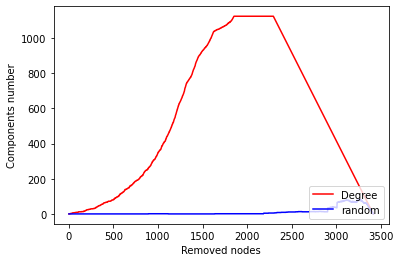

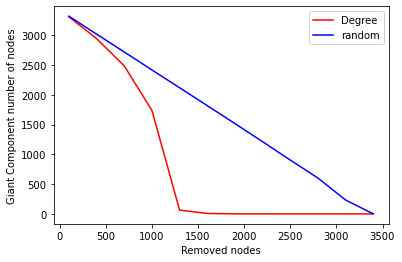

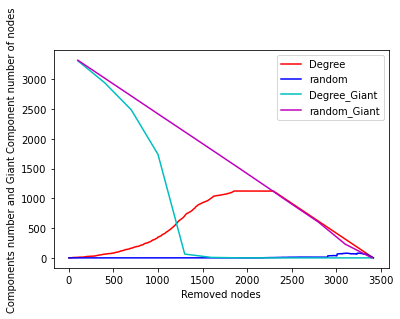

In [302]:
graph_robustness_random_dg(A1,diametersOn = False)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----
----- Nodes removed:  3400  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----
----- Nodes removed:  3400  -----
::: Plotting :::


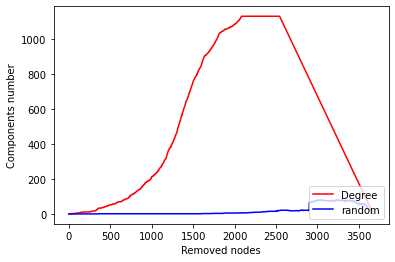

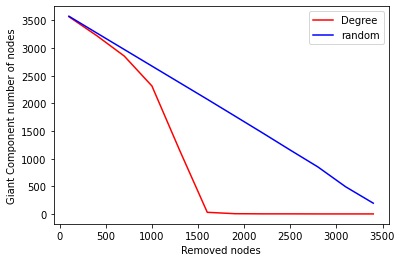

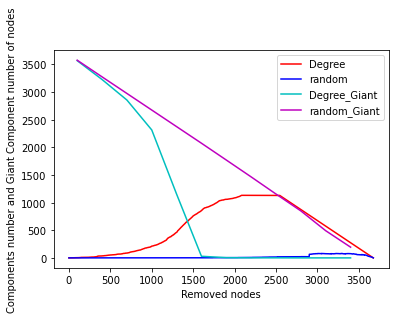

In [304]:
graph_robustness_random_dg(C1,diametersOn = False)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----
----- Nodes removed:  3400  -----
----- Nodes removed:  3700  -----
----- Nodes removed:  4000  -----
----- Nodes removed:  4300  -----
----- Nodes removed:  4600  -----
----- Nodes removed:  4900  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----


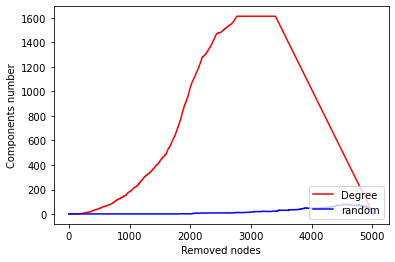

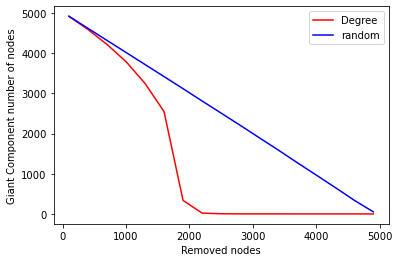

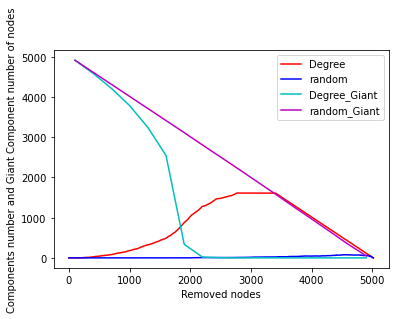

In [305]:
graph_robustness_random_dg(A2,diametersOn = False)

::: Computing Degree :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----
----- Nodes removed:  3400  -----
----- Nodes removed:  3700  -----
----- Nodes removed:  4000  -----
::: Computing for random :::
----- Nodes removed:  100  -----
----- Nodes removed:  400  -----
----- Nodes removed:  700  -----
----- Nodes removed:  1000  -----
----- Nodes removed:  1300  -----
----- Nodes removed:  1600  -----
----- Nodes removed:  1900  -----
----- Nodes removed:  2200  -----
----- Nodes removed:  2500  -----
----- Nodes removed:  2800  -----
----- Nodes removed:  3100  -----
----- Nodes removed:  3400  -----
----- Nodes removed:  3700  -----
----- Nodes removed:  4000  -----


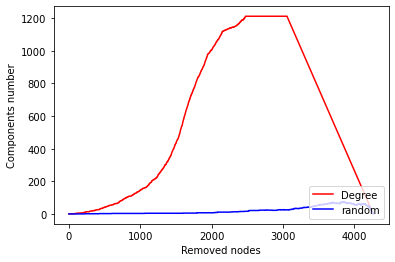

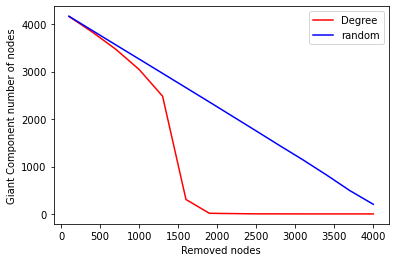

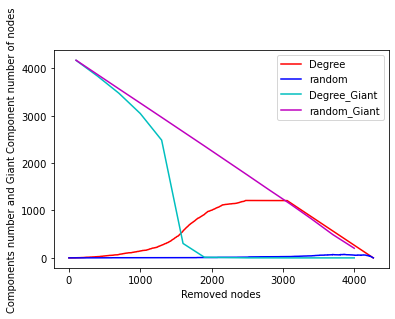

In [306]:
graph_robustness_random_dg(C2,diametersOn = False)

# NODE REMOVAL WITH LIWK RESULT , TO DO